# Test Gumbel Function

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
# tau range between [0.1-1], the smaller the closer to softmax
# self.tau = 0.3 
def gumbelSoftmax(x, tao):        
    gumbelNoiseArray = -torch.log(-torch.log((torch.rand_like(x)+0.001) / 1.002))        
    softmaxOutput = (F.softmax(x,1)+0.001) / 1.002        
    noisySoftmaxOutput = (torch.log(softmaxOutput)+gumbelNoiseArray) / tao
    return F.sigmoid(noisySoftmaxOutput)

# Test Top-Down Attention Structure

In [1]:
# Load arguments
import os
import re
import utils
import torch
import random
import string
import pickle
import matplotlib
import numpy as np
import pandas as pd
import utils.options
import torch.nn as nn
import scipy.io as sio
import torch.nn.functional as F
from nltk.stem import PorterStemmer
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from utils.video_dataset import Dataset
from tensorboard_logger import log_value
from utils.detectionMAP import getDetectionMAP as dmAP
from utils.classificationMAP import getClassificationMAP as cmAP
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt
%matplotlib inline  

class Args():
    def __init__(self):
        self.lr = 0.0001
        self.dataset_name = 'Thumos14reduced'
        self.num_class = 20
        self.feature_size = 2048
        self.batch_size = 24
        self.max_seqlen = 750
        self.model_name = 'weakloc'
        self.pretrained_ckpt = None
        self.max_iter = 50000
        self.num_similar = 3
        self.checkpoint_path = './checkpoint/'
        self.annotation_path = './annotations/'
        self.I3D_path = './I3D_features/'


# Category to sentence
class_name = {0: ["baseball pitch", "throw a baseball", "baseball throw"],
             1: ["basketball dunk", "dunk a basketball", "slam dunk basketball"],
             2: ["billiards"],
             3: ["clean and jerk", "weight lifting movement"],
             4: ["cliff diving", "high diving", "diving"],
             5: ["cricket shot" ],
             6: ["cricket bowling", "cricket movement", "bowl cricket"],
             7: ["diving", "jumping into water", "falling into water"],
             8: ["frisbee catch", "catch frisbee"],
             9: ["golf swing", "golf stroke"],
            10: ["hammer throw", "throw a hammer"],
            11: ["high jump"],
            12: ["javelin throw", "throw a spear"],
            13: ["long jump", "jump contest"],
            14: ["pole vault", "a person uses a long flexible pole to jump over a bar"],
            15: ["shot put"],
            16: ["soccer penalty"],
            17: ["tennis swing"],
            18: ["throw discus", "discus"],
            19: ["volleyball spiking", "volleyball", ]}



# Adaptive Margin Loss
class Adaptive_Margin_Loss(torch.nn.Module):
    """
    Adaptive margin loss penalize on the (pos, neg, lang) triples.
    Input:
    feat_pos:    (batch, 100)
    feat_neg:    (batch, # clips, 100)
    feat_lan:    (batch, 100)
    Refers to the document for equation.
    return loss1 + lambda*loss2
    """
    def __init__(self):
        super(Adaptive_Margin_Loss,self).__init__()
        
    def forward(self, feat_pos, feat_neg, feat_lan, margin=0.1, lamda=1):
        loss1 = euclidean_distance(feat_pos, feat_lan)
        loss2 = 0
        total = 0
        # Iterate through all batch
        for idx1, feats in enumerate(feat_neg):
            total += feats.shape[0]
            for idx2, feat in enumerate(feats):
                loss2 += torch.max(torch.zeros(1), margin-euclidean_distance(feat_pos[idx1], feat))
        loss2 /= total
        return loss1 + lamda*loss2[0]
    

    
args = Args()

# Load the dataset
dataset = Dataset(args)

# Define loss function
adaptive_margin_loss = Adaptive_Margin_Loss()

# Word Embedding Loading from GLOVE
path_to_glove = './checkpoint/glove.840B.300d.pkl'

with open(path_to_glove, "rb") as input_file:
    glove_model = pickle.load(input_file)
    

In [100]:
# Convert attention list to binary gates
def attention_to_binary(attention_weights):
    result = []
    for attention in attention_weights:
        threshold = (torch.max(attention) - (torch.max(attention) - torch.min(attention))*0.5)
        result.append([1 if s > threshold else 0 for idx, s in enumerate(attention)])
    return result


# Randomly selecting out single label and cnovert it to text
def one_label_text(labels, test=False):
    if not test:
        tem_labels = torch.zeros_like(labels)
        target = [[idx for idx, item in enumerate(label.tolist()) if item == 1] for label in labels]
        for i, l in enumerate(target):
            idx = np.random.choice(l)
            tem_labels[i][idx] = 1
        text = label_to_text(tem_labels)
        return text, tem_labels
    else:
        target = [idx for idx, item in enumerate(labels.tolist()) if item == 1.]
        if len(target) == 0:
            print('Error here, not valid label assigned for this test case!')
            target.append(0)
        return_labels = torch.zeros(len(target), labels.shape[0])
        return_text = []
        for i, t in enumerate(target):
            return_labels[i][t] = 1
            text = label_to_text([return_labels[i]])
            return_text.append(text)
        return return_text, return_labels
    


# Stacking all laebls to language format
def label_to_text(labels):
    text_list = []
    for label in labels:
        idxs = [idx for idx, val in enumerate(label) if val==1]
        text = ''
        for idx in idxs:
            text += ' ' + random.choice(class_name[idx])
        text_list.append(text)
    return text_list


# L1 normalization for weights regularization
def l1_norm(inputs):
    norm_value = torch.zeros(len(inputs)).cuda()
    for idx, vector in enumerate(inputs):
        norm_value[idx] = torch.norm(torch.abs(vector), p=1)
    return norm_value.sum()


# Sample single label from multi ground truth
def multi_to_single(labels):
    l = []
    for lab in labels:
        l.append(lab.tolist().index(1))
    return torch.from_numpy(np.asarray(l)).cuda()


# T-cam with specific label
def temporal_proposals(weights, features, clses):
    """
        Return the binary temporal proposals based on T-CAM.
        Input: 
            features:    (batch, # of segments, # of dim)
            cls:         (batch, class_label)
        Return:    [batch, # of untrimmed segments(binary)]
    """
    proposals = []
    # Iterate through batch
    for idx, video_feature in enumerate(features):
        # Chunk video feature to real length
            seq_len = (torch.abs(video_feature).max(dim=1)[0] > 0).sum().tolist()
            video_feature = video_feature[: seq_len, :]
            scores = np.zeros(seq_len)
            for seg_id, feature in enumerate(video_feature):
                for cls in clses[idx]:
                    score = (feature*weights[cls]).sum()
                    scores[seg_id] += score
            # Labeling segments with scores larger than threshold
            threshold = (np.max(scores) - (np.max(scores) - np.min(scores))*0.5)
            proposals.append([1 if s > threshold else 0 for idx, s in enumerate(scores)])
    return proposals


def temp2(length, attention_list, labels):
    weights = torch.zeros(length, 20)
    idx_list = [i for i, val in enumerate(labels) if val == 1.0]
    for idx, val in enumerate(idx_list):
        weights[:, val] = attention_list[idx]
    return weights


  
class Model(nn.Module):
    """Args:
        Video I3D features and raw natural text.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, time_steps, output_dim=100, 
                 num_layers=2, path_to_glove = './checkpoint/glove.840B.300d.pkl'):
        super(Model, self).__init__()
        """
            Create Duo Strean Model.
        """
        self.textual_model = Language_encoder(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers, path_to_glove
                                              =path_to_glove)
        self.visual_model = Visual_model()
    
    def forward(self, visual_feature, text, t_proposals=None, test=False):
        """
            pos/neg_feature: (batch, 2048).       
                mean_pooled representations.
        """
        textual_feature = self.textual_model(text)
        attention_weights, visual_feature, pos_feature, neg_feature, test_features = \
            self.visual_model(visual_feature, text, t_proposals=t_proposals, test=test)

        return attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features
    
    

# Build up the language model and LSTM
class Language_encoder(nn.Module):
    """Args:
        Natural Language Text.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, time_steps, output_dim=100, 
                 num_layers=2, path_to_glove = './checkpoint/glove.840B.300d.pkl'):
        super(Language_encoder, self).__init__()
        """
            Load GLOVE pre-trained model first.
        """
        with open(path_to_glove, "rb") as input_file:
            self.glove = pickle.load(input_file)
        self.wordnet_lemmatizer = WordNetLemmatizer() 

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.time_steps = time_steps
        
        # Define the LSTM/fc module
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def language_preprocess(self, input_str):
        # convert to lowercase
        input_str = input_str.lower()
        # remove numbers
        input_str = re.sub(r'\d+', '', input_str)
        # remove punctuation
        input_str = re.sub(r'[^\w\s]','',input_str)
        # remove whitespaces
        input_str = input_str.strip()
        # remove stop words
        stop_words = set(ENGLISH_STOP_WORDS)
        tokens = word_tokenize(input_str)
        words = [i for i in tokens if not i in stop_words]
        # stemming the words
        words = [self.wordnet_lemmatizer.lemmatize(word) for word in words]
        return words
    
    def zero_pad_feature(self, word_dict):
        # transform to tensor input, and zero padding the extra feature
        input_seq = torch.zeros(self.time_steps, len(word_dict), lstm_input_size).cuda()
        
        for i in range(len(word_dict)):
            for j in range(self.time_steps):
                if j < len(word_dict[i]):
                    # word2vec extracting
                    input_seq[j, i, :] = torch.from_numpy(glove_model[word_dict[i][j]]).cuda()
        return input_seq
    
    def forward(self, text):
        """
            Text will be pre-processed first, and zero-padded for LSTM input.
        """
        word_dict = []
        for lines in text:
            word_dict.append(self.language_preprocess(lines))
        input_seq = self.zero_pad_feature(word_dict)
        
        lstm_out, _ = self.lstm(input_seq)
        last_output = lstm_out[-1]
        output = self.linear(last_output)
        
        return output


    
class Visual_model(nn.Module):
    """Args:
    feature_dim: dimension of the feature from I3D model.
    """

    def __init__(self, feature_dim=2048):
        super(Visual_model, self).__init__()
        
        self.feature_dim = feature_dim
        self.fc0 = nn.Linear(feature_dim, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc_lr = nn.Linear(2048, 100)
        self.language_encoder = Language_encoder(300, 300, batch_size=1, time_steps=8, output_dim=256, num_layers=2, 
                                            path_to_glove=path_to_glove)
        
        # Bilinear Module: input: (# seg * 2048d), (1 * 300d); output: (# seg * 256)
        self.bilinear_pooling = nn.Bilinear(256, 100, 256)

    def forward(self, features_list, text_list, t_proposals=None, test=False):
        """Build the attention module.

        Args:
        features_list: (batch_size, num_frame, feat_depth)
        t_proposals:    temporal proposals generated from T-CAM, for boostrapping LSTM training.
        language_vector: top-down signal, (batch_size, feat_dim)

        Returns:
        The attention weights, weigted features
        """
        # Test_features are returning tensors (batch, length, feat_dim)
        attention_weights = []
        weighted_features = []
        pos_features = []
        neg_features = []
        test_features = []
        text_features = self.language_encoder(text_list)
        
        # Iterate through batch since length of each video segment varies
        for idx, video_features in enumerate(features_list):
            # Trunk feature into real length
            seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
            video_features = video_features[: seq_len, :]

            # Expand the size of language size
            language_feat = text_features[idx]
            language_feat = self.sigmoid(language_feat.expand(video_features.shape[0], language_feat.shape[-1]))

            # Iterate through video segments
            bilinear = self.relu(self.fc1(self.relu(self.fc0(video_features)))*language_feat)
            output = self.sigmoid(self.fc2(bilinear))
#             output = gumbelSoftmax(self.fc2(bilinear), args.tao)

            # Temporal Pool
            weighted_pooling = (output*video_features).sum(0)/video_features.shape[0]
            
            # If testing, feed weighted video_features (no mean pool) to fc_lr
            if test:
                test_features.append(self.fc_lr((output*video_features)))
            
            # Save weights/features
            output = output.reshape(output.shape[0])
            attention_weights.append(output)
            weighted_features.append(weighted_pooling)

            # Pool pos/neg segments features from T-CAM proposals
            if t_proposals is not None:
                pos_list = [index for index, l in enumerate(t_proposals[idx]) if l == 1.]
                neg_list = [index for index, l in enumerate(t_proposals[idx]) if l == 0.]
                # Reduce mean over positive and negative video features
                pos_feature = torch.stack([feat for index, feat in enumerate(video_features) 
                                           if index in pos_list]).sum(0)/len(pos_list)
                neg_feature = torch.stack([feat for index, feat in enumerate(video_features) 
                                           if index in neg_list]).sum(0)/len(neg_list)

                pos_features.append(pos_feature)
                neg_features.append(neg_feature)
            # If provide no T-Proposals, we generate pos-neg through self attention
            else:
                # Retrieve pos-neg pairs according to threshold
                pos_neg = attention_to_binary(output.reshape((1, -1)))[0]
                pos_list = [index for index, l in enumerate(pos_neg) if l == 1.]
                neg_list = [index for index, l in enumerate(pos_neg) if l == 0.]
                pos_feature = torch.stack([feat for index, feat in enumerate(video_features) 
                                           if index in pos_list]).sum(0)/len(pos_list)
                neg_feature = torch.stack([feat for index, feat in enumerate(video_features) 
                                           if index in neg_list])
                pos_features.append(pos_feature)
                neg_features.append(self.fc_lr(neg_feature))
                
        # Reshape to tensor
        weighted_features = torch.stack(weighted_features)

        # Feed temporal features to fc regression layer
        # output: aggregated visual representations
        output = self.fc_lr(weighted_features)
        
        if test:
            return attention_weights, output, None, None, test_features
        else:
            # training without t-cam bootstrapping
            if t_proposals is None:
                pos_features = torch.stack(pos_features)
                pos_features = self.fc_lr(pos_features)
                return attention_weights, output, pos_features, neg_features, None
            # training with t-cam bootstrapping
            else:
                pos_features = torch.stack(pos_features)
                neg_features = torch.stack(neg_features)
                pos_features = self.fc_lr(pos_features)
                neg_features = self.fc_lr(neg_features)
                return attention_weights, output, pos_features, neg_features, None
            

In [110]:
# Duo Model testing
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

model = Model(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)

# Load pre-trained classification network for bootstrapping
checkpoint = torch.load('./checkpoint/T-CAM.pth')
pretrained_dict = checkpoint['state_dict']
fc_weight = pretrained_dict['fc3.weight']

# filter out unnecessary keys and load valid params
model_dict = model.state_dict()
checkpoint = torch.load('./checkpoint/LSTM-marginloss-topdown.pth')
pretrained_dict = checkpoint['state_dict']
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)  
model.load_state_dict(model_dict)


model.cuda()
model.textual_model.cuda()
model.visual_model.cuda()
print('model created')

# Store the fc weights for t-cam prediction
# args.weights = model.visual_model.fc3.weight.detach().cpu()
args.weights = fc_weight.cpu()
args.tao = 0.9
args.lr = 0.01

# Loss defined here
marginrankingloss = nn.MarginRankingLoss(0.1)

def euclidean_distance(v1, v2, dim=None):
    if dim is not None: 
        return torch.mean((v1-v2)**2, dim)
    else:
        return torch.mean((v1-v2)**2)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

writer = SummaryWriter()

model created


### Training with T-CAM to be Bootstrapping, after 200 epoch, then we use self generated attention

Epoch:000, Loss: 0.0913911759853363


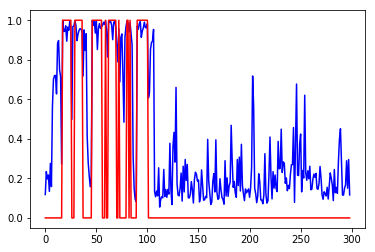

Epoch:020, Loss: 0.09026379138231277


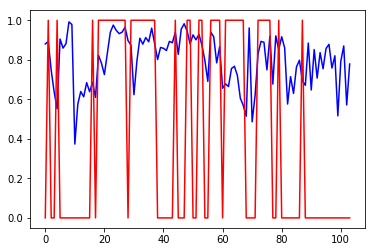

Epoch:040, Loss: 0.08842763304710388


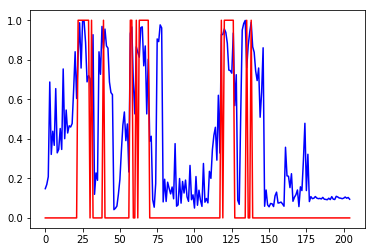

Epoch:060, Loss: 0.08506003767251968


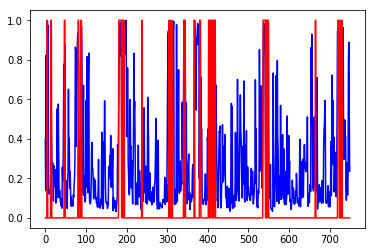

Epoch:080, Loss: 0.08007791638374329


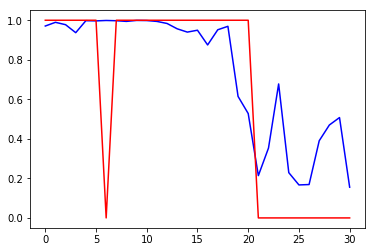

Epoch:100, Loss: 0.08024913817644119


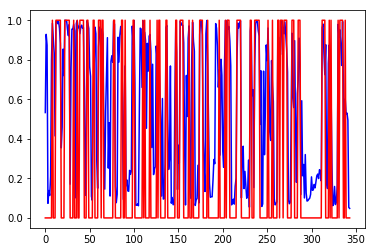

Epoch:120, Loss: 0.07005787640810013


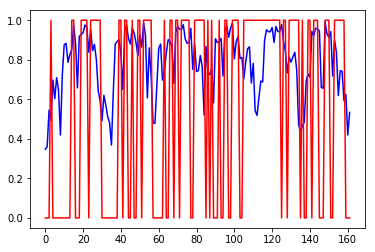

Epoch:140, Loss: 0.07369904220104218


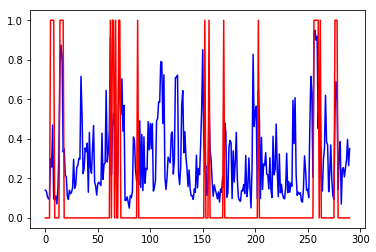

Epoch:160, Loss: 0.05907745659351349


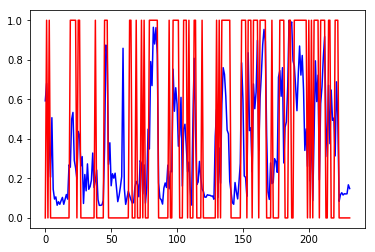

Epoch:180, Loss: 0.04833389073610306


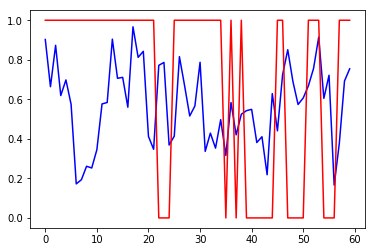

Epoch:200, Loss: 0.04666104540228844


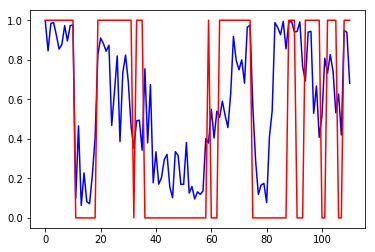

Epoch:220, Loss: 0.045702967792749405


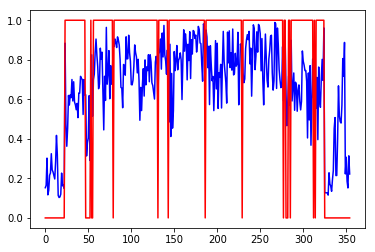

Epoch:240, Loss: 0.04230804368853569


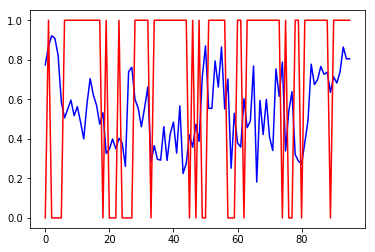

Epoch:260, Loss: 0.03913625329732895


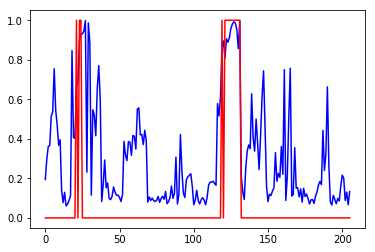

Epoch:280, Loss: 0.039101969450712204


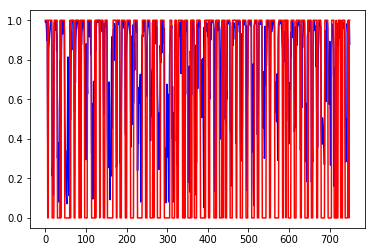

Epoch:300, Loss: 0.03318806737661362


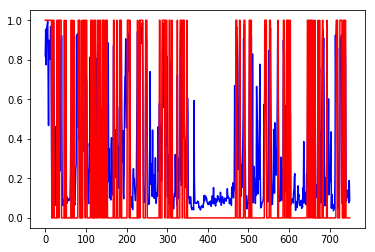

Epoch:320, Loss: 0.03144712373614311


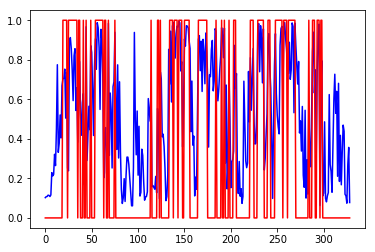

Epoch:340, Loss: 0.0358240008354187


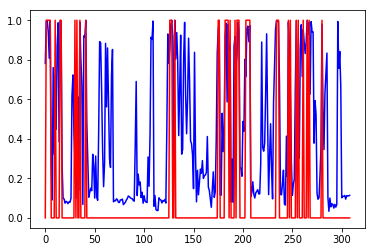

Epoch:360, Loss: 0.03228263929486275


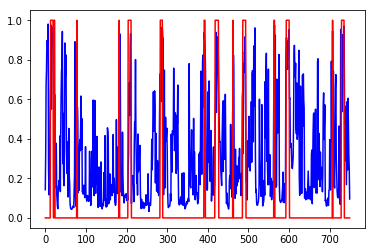

Epoch:380, Loss: 0.030780423432588577


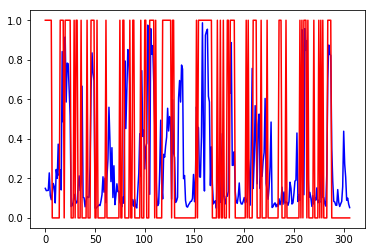

Epoch:400, Loss: 0.025856031104922295


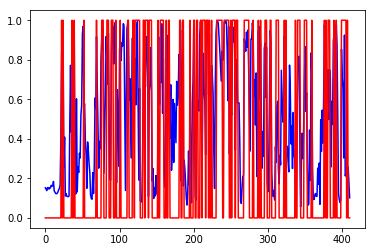

Epoch:420, Loss: 0.0268136877566576


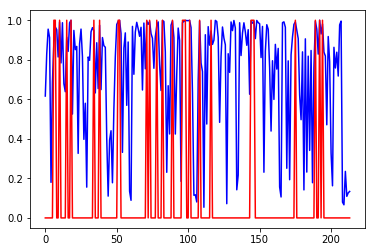

Epoch:440, Loss: 0.025434762239456177


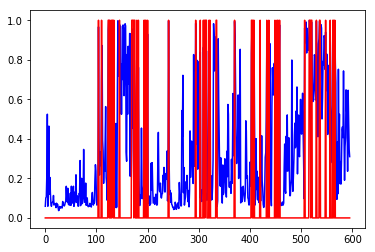

Epoch:460, Loss: 0.026176447048783302


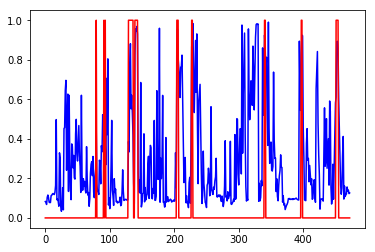

Epoch:480, Loss: 0.028026975691318512


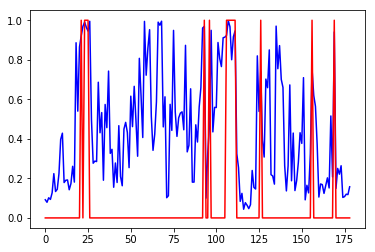

Epoch:500, Loss: 0.02040180377662182


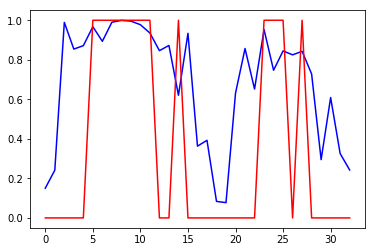

Epoch:520, Loss: 0.022204037755727768


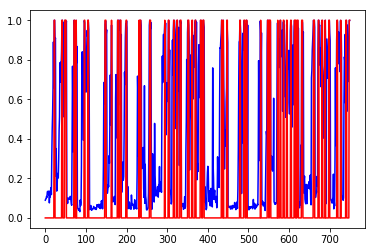

Epoch:540, Loss: 0.01948600821197033


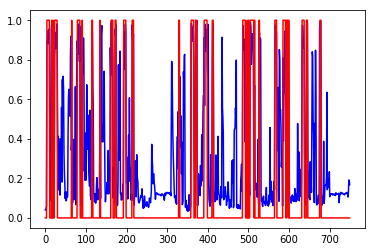

Epoch:560, Loss: 0.030800797045230865


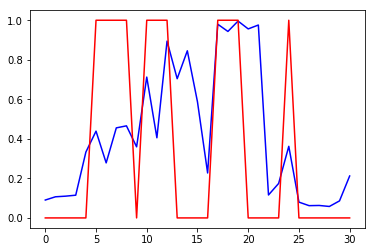

Epoch:580, Loss: 0.020134638994932175


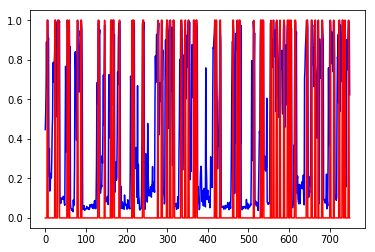

Epoch:600, Loss: 0.02210972085595131


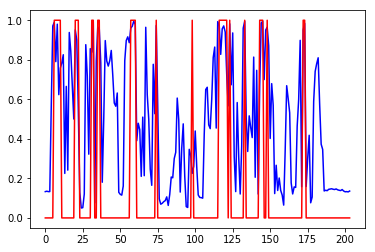

Epoch:620, Loss: 0.028081178665161133


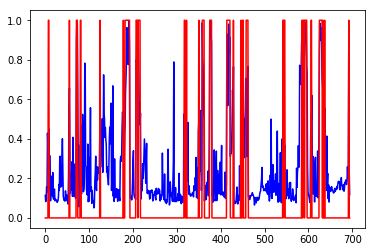

Epoch:640, Loss: 0.022882621735334396


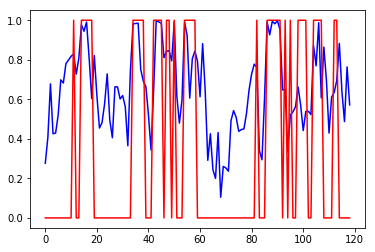

Epoch:660, Loss: 0.024449897930026054


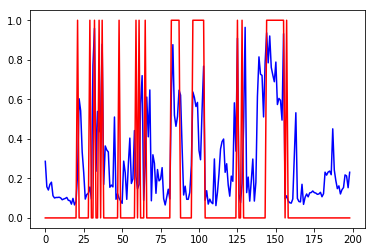

Epoch:680, Loss: 0.019849475473165512


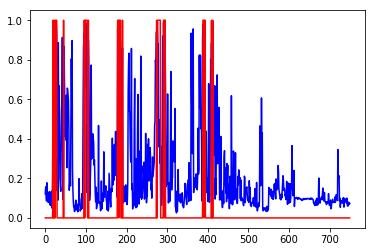

Epoch:700, Loss: 0.01770293526351452


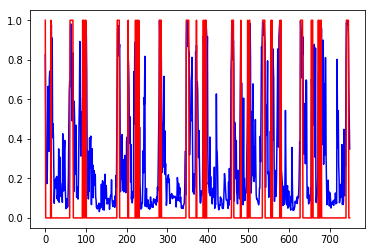

Epoch:720, Loss: 0.020168503746390343


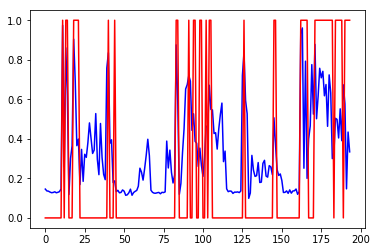

Epoch:740, Loss: 0.024009404703974724


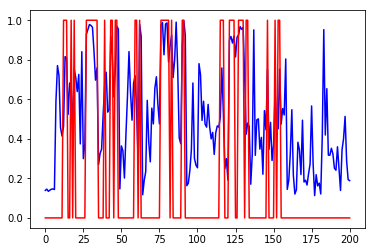

Epoch:760, Loss: 0.019714195281267166


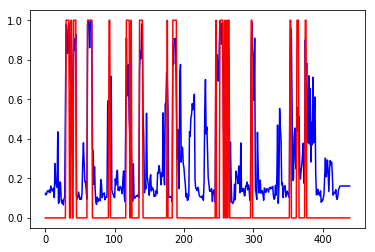

Epoch:780, Loss: 0.028215721249580383


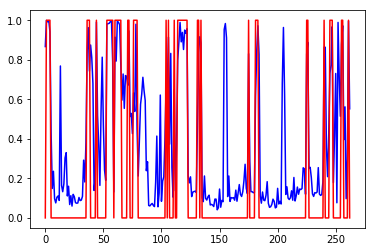

Epoch:800, Loss: 0.02540270984172821


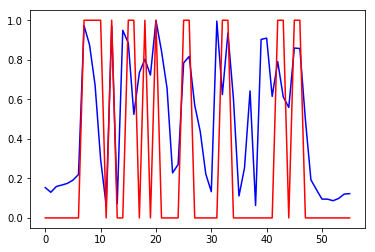

Epoch:820, Loss: 0.02181919664144516


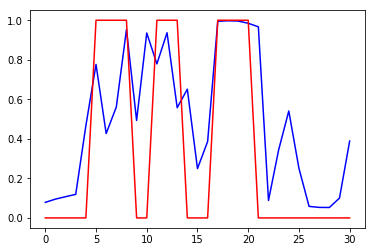

Epoch:840, Loss: 0.02701982855796814


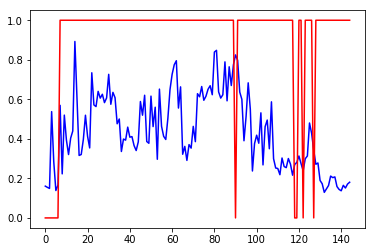

Epoch:860, Loss: 0.017353853210806847


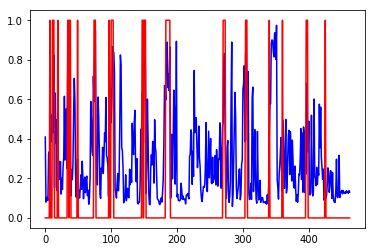

Epoch:880, Loss: 0.03193235397338867


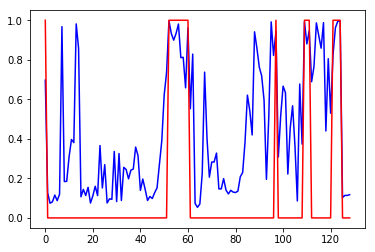

Epoch:900, Loss: 0.02798641100525856


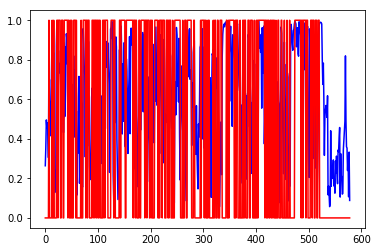

Epoch:920, Loss: 0.021296825259923935


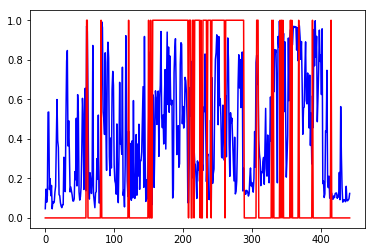

Epoch:940, Loss: 0.0169367715716362


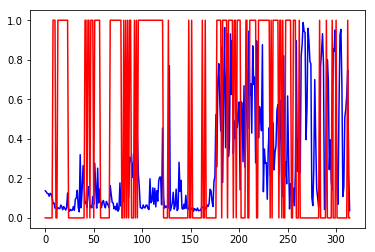

Epoch:960, Loss: 0.016588367521762848


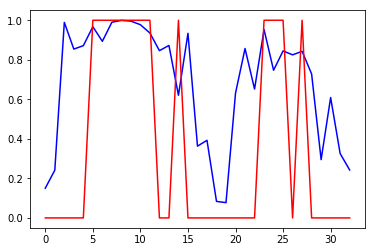

Epoch:980, Loss: 0.021563049405813217


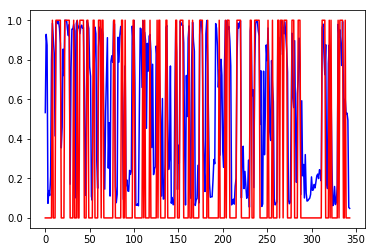

Epoch:1000, Loss: 0.02299170196056366


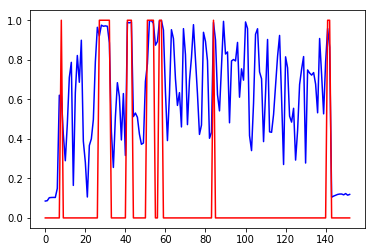

Epoch:1020, Loss: 0.019994085654616356


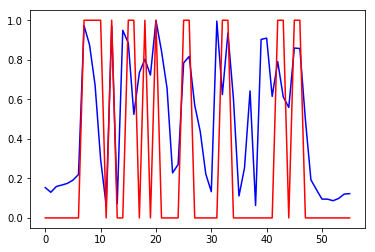

Epoch:1040, Loss: 0.020694848150014877


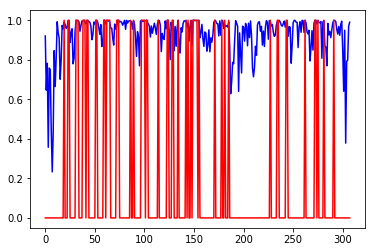

Epoch:1060, Loss: 0.01942899078130722


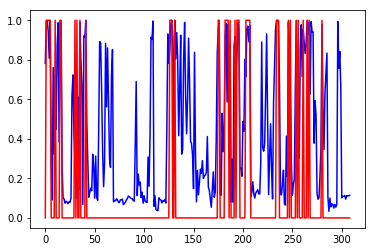

Epoch:1080, Loss: 0.015718258917331696


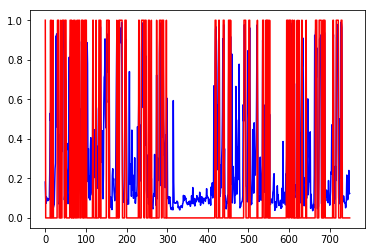

Epoch:1100, Loss: 0.0220116525888443


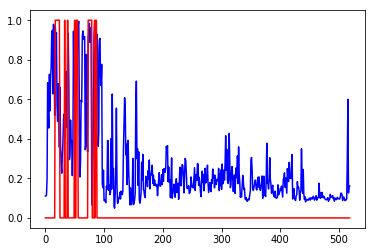

Epoch:1120, Loss: 0.015057802200317383


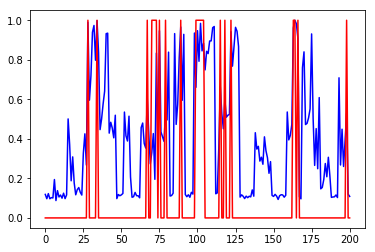

Epoch:1140, Loss: 0.015977714210748672


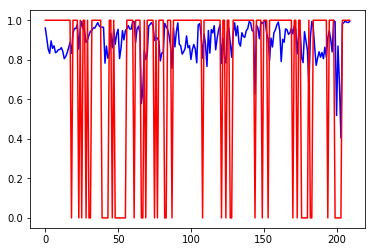

Epoch:1160, Loss: 0.017618592828512192


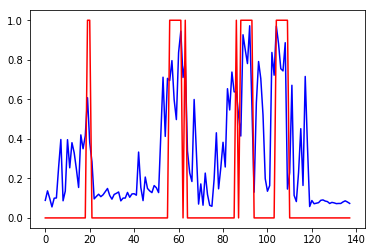

Epoch:1180, Loss: 0.01756937988102436


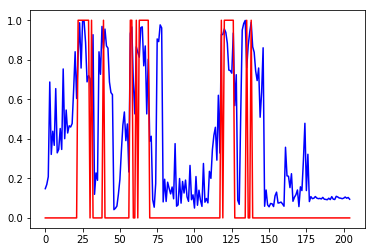

Epoch:1200, Loss: 0.0170054379850626


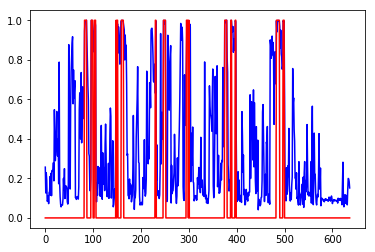

Epoch:1220, Loss: 0.018622610718011856


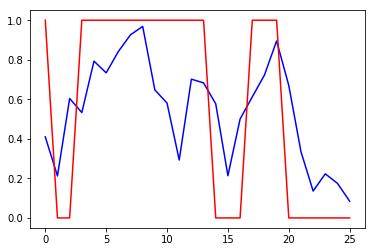

Epoch:1240, Loss: 0.014909395948052406


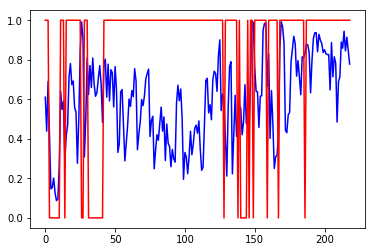

Epoch:1260, Loss: 0.021023308858275414


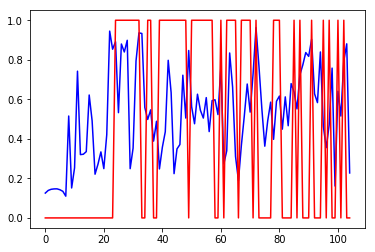

Epoch:1280, Loss: 0.01608380675315857


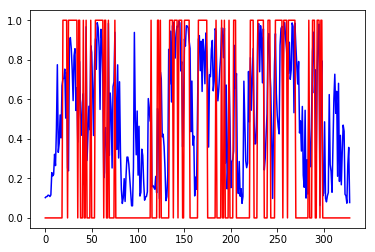

Epoch:1300, Loss: 0.018917210400104523


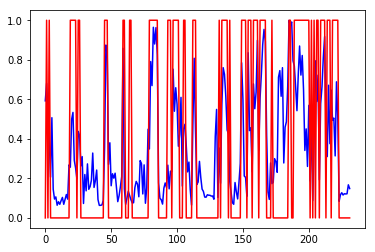

Epoch:1320, Loss: 0.01670170947909355


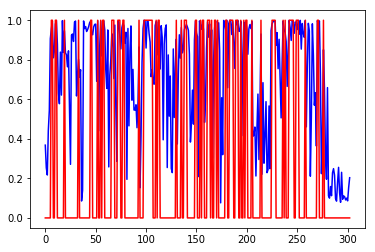

Epoch:1340, Loss: 0.017327753826975822


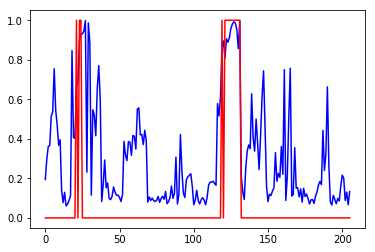

Epoch:1360, Loss: 0.01939663290977478


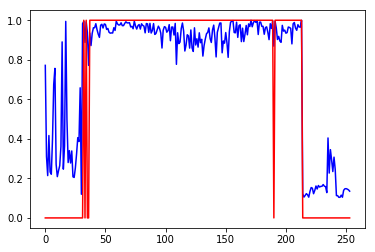

Epoch:1380, Loss: 0.01580219529569149


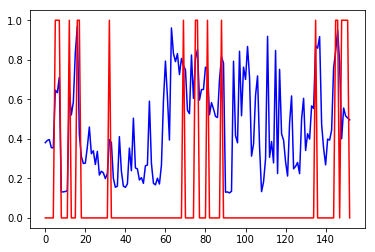

Epoch:1400, Loss: 0.015995508059859276


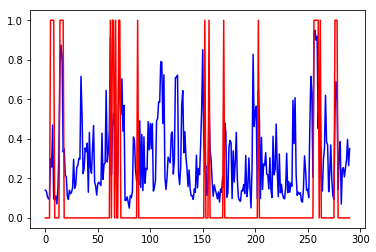

Epoch:1420, Loss: 0.01922214962542057


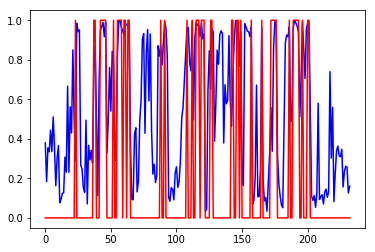

Epoch:1440, Loss: 0.015235204249620438


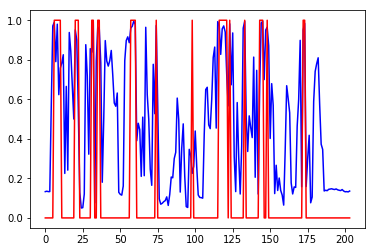

Epoch:1460, Loss: 0.013889072462916374


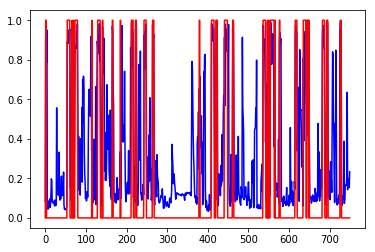

Epoch:1480, Loss: 0.01936125010251999


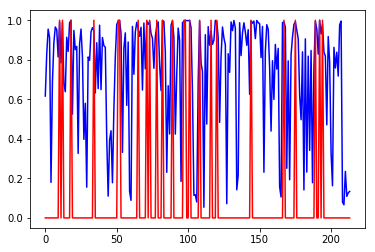

Epoch:1500, Loss: 0.012988397851586342


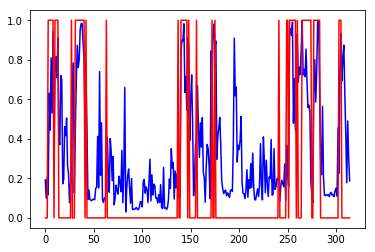

Epoch:1520, Loss: 0.019773604348301888


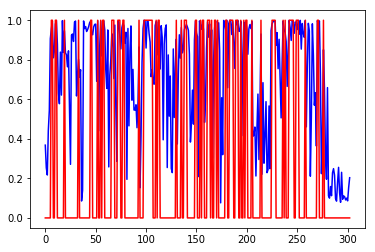

Epoch:1540, Loss: 0.01904524303972721


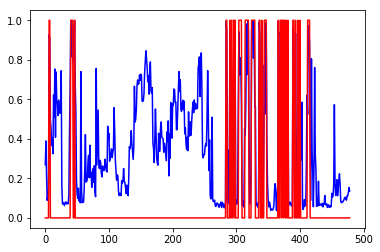

Epoch:1560, Loss: 0.012377014383673668


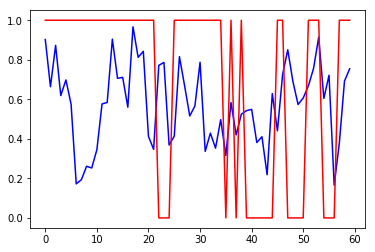

Epoch:1580, Loss: 0.017174405977129936


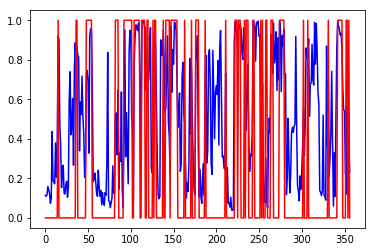

Epoch:1600, Loss: 0.019340496510267258


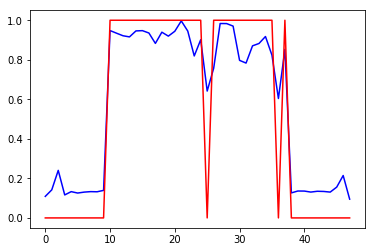

Epoch:1620, Loss: 0.016148941591382027


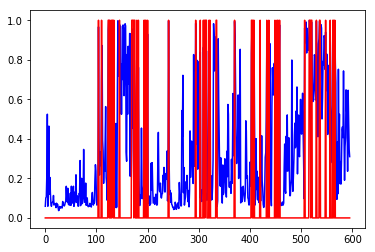

Epoch:1640, Loss: 0.014182811602950096


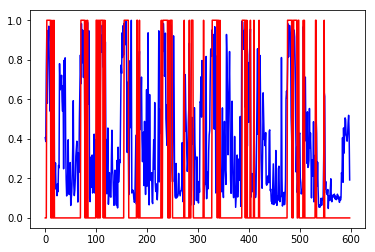

Epoch:1660, Loss: 0.01522592082619667


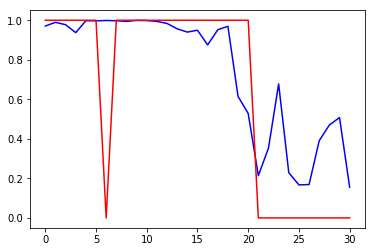

Epoch:1680, Loss: 0.013666650280356407


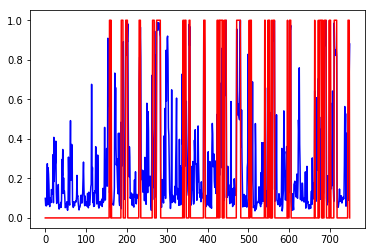

Epoch:1700, Loss: 0.013889460824429989


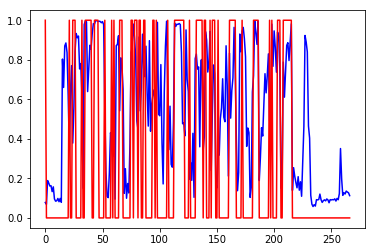

Epoch:1720, Loss: 0.016352972015738487


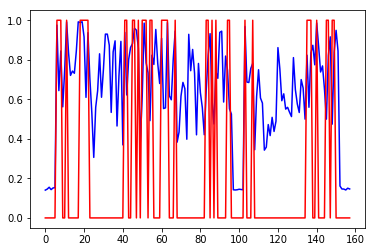

Epoch:1740, Loss: 0.015055723488330841


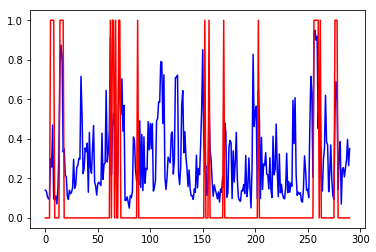

Epoch:1760, Loss: 0.016837304458022118


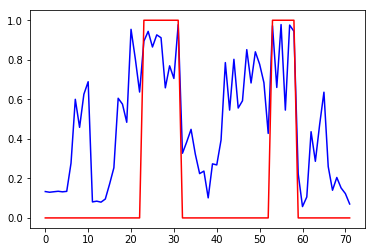

Epoch:1780, Loss: 0.013414467684924603


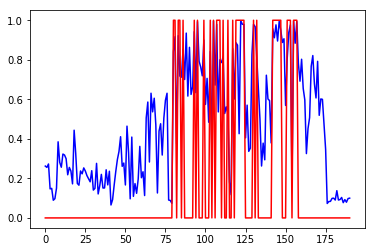

Epoch:1800, Loss: 0.013022240251302719


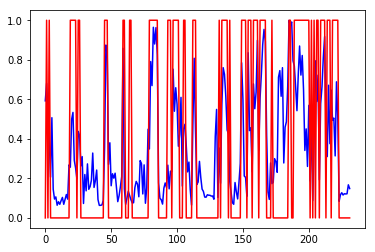

Epoch:1820, Loss: 0.0142505569383502


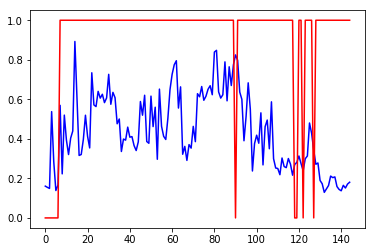

Epoch:1840, Loss: 0.018254229798913002


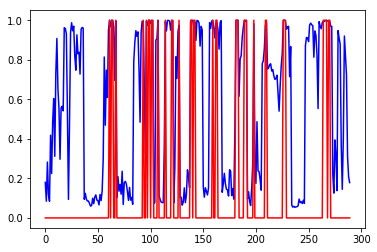

Epoch:1860, Loss: 0.013808812946081161


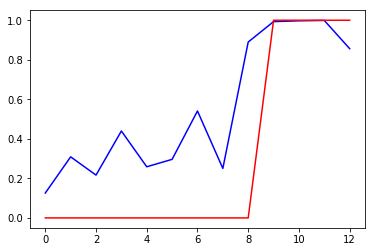

Epoch:1880, Loss: 0.015103615820407867


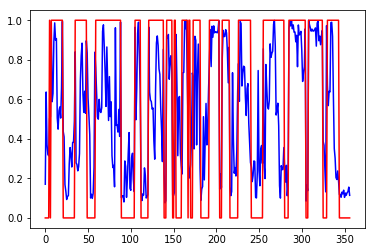

Epoch:1900, Loss: 0.010347044095396996


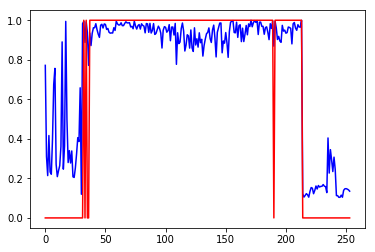

Epoch:1920, Loss: 0.014222642406821251


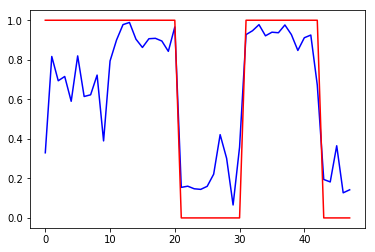

Epoch:1940, Loss: 0.012022826820611954


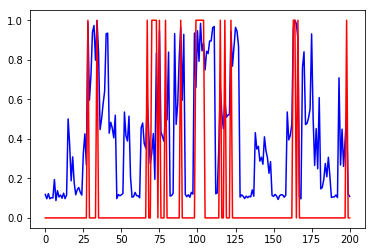

Epoch:1960, Loss: 0.012069489806890488


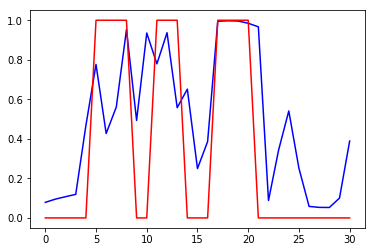

Epoch:1980, Loss: 0.018163835629820824


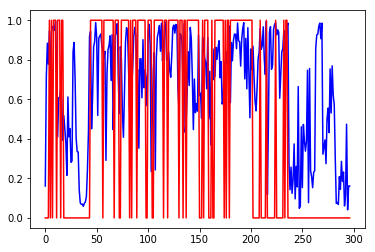

Epoch:2000, Loss: 0.021781768649816513


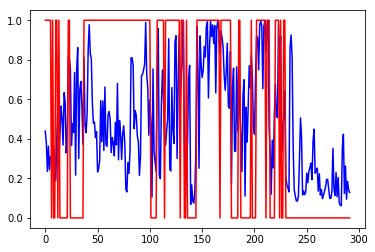

Epoch:2020, Loss: 0.014565320685505867


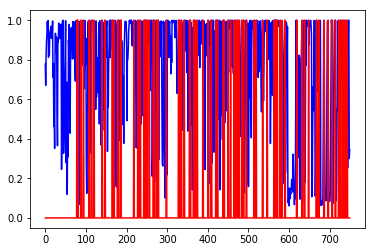

Epoch:2040, Loss: 0.013200696557760239


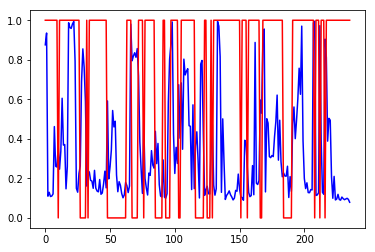

Epoch:2060, Loss: 0.013302424922585487


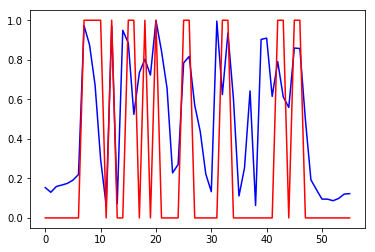

Epoch:2080, Loss: 0.013743683695793152


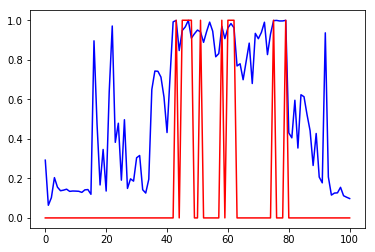

Epoch:2100, Loss: 0.010936305858194828


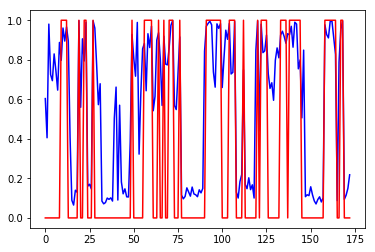

Epoch:2120, Loss: 0.015304621309041977


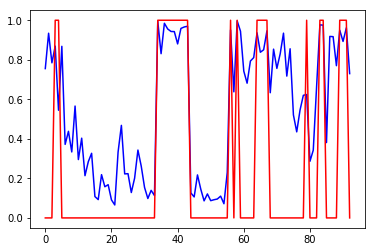

Epoch:2140, Loss: 0.01605330780148506


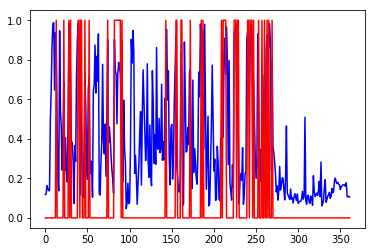

Epoch:2160, Loss: 0.012479926459491253


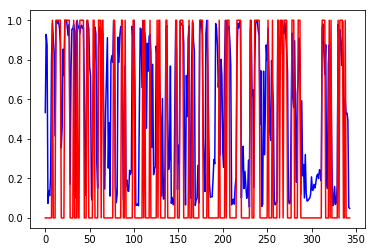

Epoch:2180, Loss: 0.01758049987256527


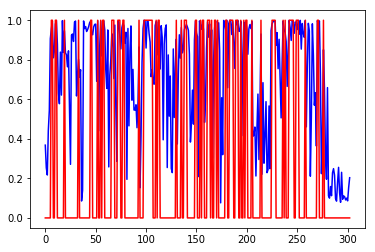

Epoch:2200, Loss: 0.015383871272206306


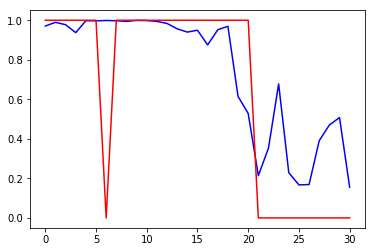

Epoch:2220, Loss: 0.01579875499010086


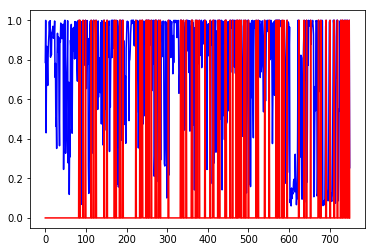

Epoch:2240, Loss: 0.01278488989919424


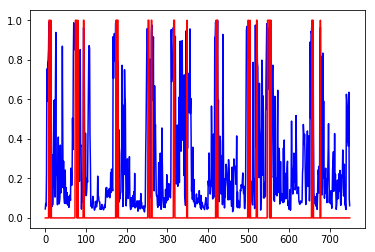

Epoch:2260, Loss: 0.011940797790884972


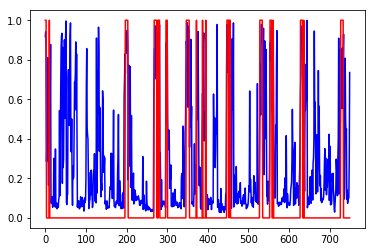

Epoch:2280, Loss: 0.011144716292619705


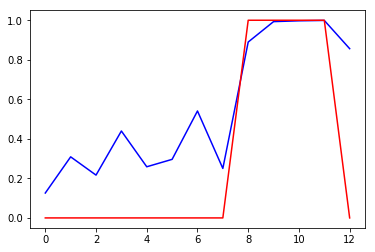

Epoch:2300, Loss: 0.009846460074186325


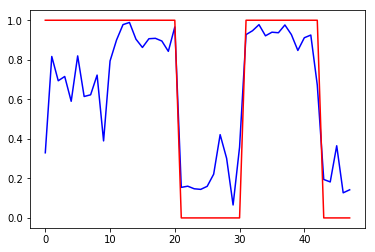

Epoch:2320, Loss: 0.016513504087924957


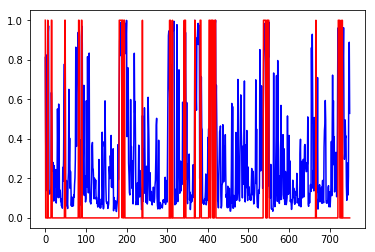

Epoch:2340, Loss: 0.013541337102651596


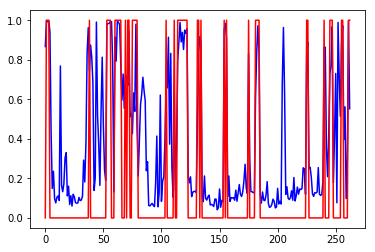

Epoch:2360, Loss: 0.009126589633524418


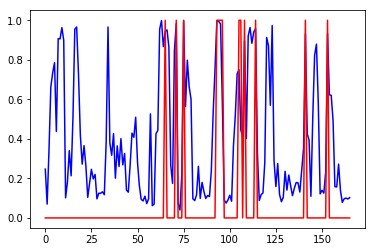

Epoch:2380, Loss: 0.01304225530475378


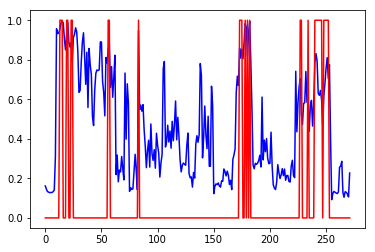

Epoch:2400, Loss: 0.018128298223018646


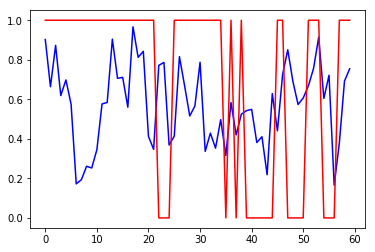

Epoch:2420, Loss: 0.012244133278727531


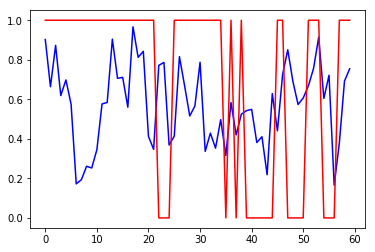

Epoch:2440, Loss: 0.014002878218889236


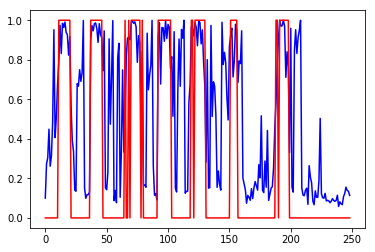

Epoch:2460, Loss: 0.012689923867583275


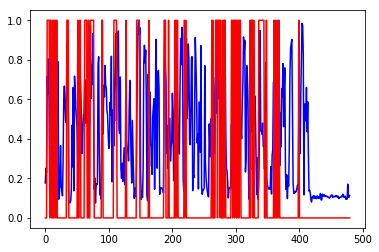

Epoch:2480, Loss: 0.008692527189850807


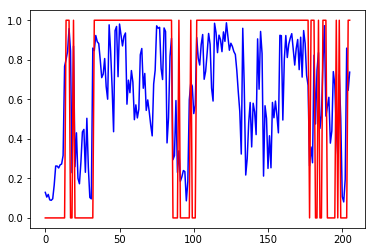

Epoch:2500, Loss: 0.014277725480496883


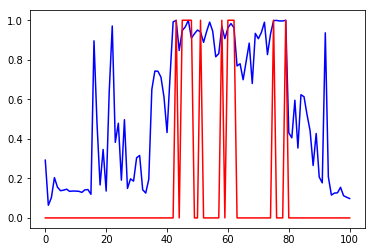

Epoch:2520, Loss: 0.013021840713918209


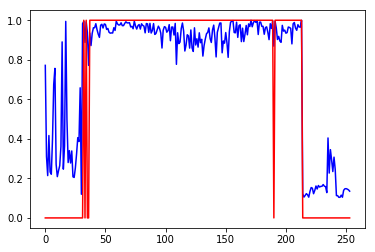

Epoch:2540, Loss: 0.010101381689310074


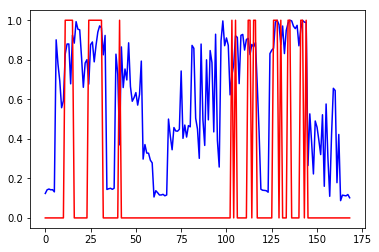

Epoch:2560, Loss: 0.012845267541706562


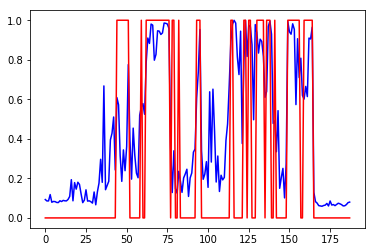

Epoch:2580, Loss: 0.01316755823791027


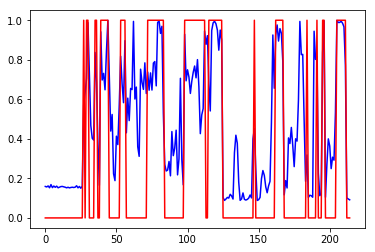

Epoch:2600, Loss: 0.008117150515317917


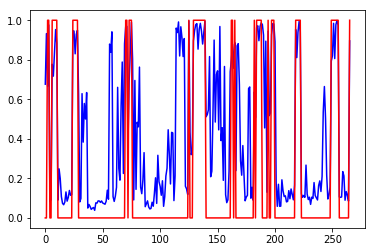

Epoch:2620, Loss: 0.010721010155975819


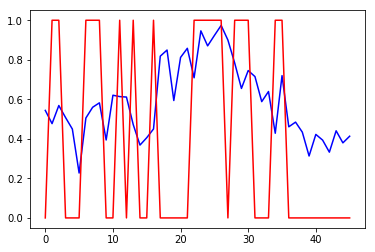

Epoch:2640, Loss: 0.010548330843448639


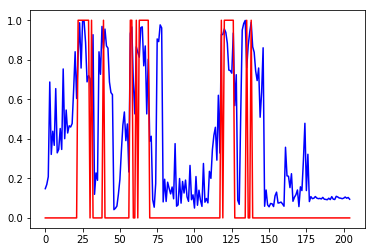

Epoch:2660, Loss: 0.013216869905591011


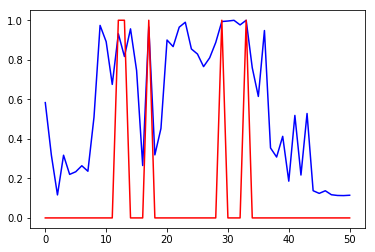

Epoch:2680, Loss: 0.008193651214241982


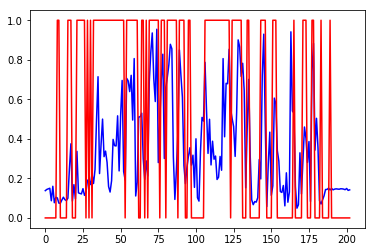

Epoch:2700, Loss: 0.00948261097073555


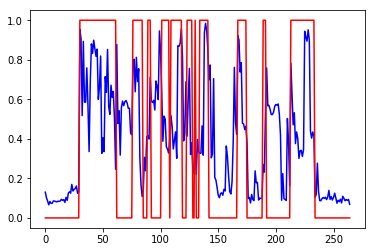

Epoch:2720, Loss: 0.011762882582843304


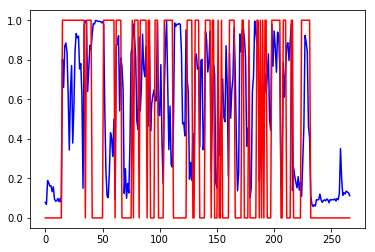

Epoch:2740, Loss: 0.009005269035696983


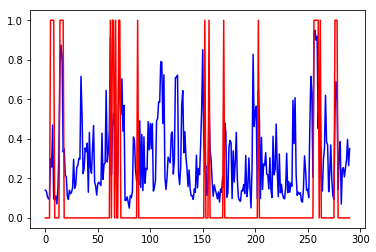

Epoch:2760, Loss: 0.008964911103248596


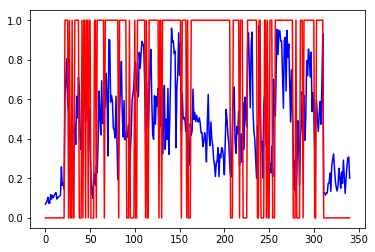

Epoch:2780, Loss: 0.014435439370572567


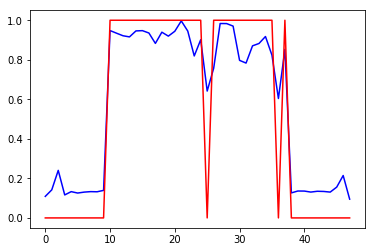

Epoch:2800, Loss: 0.010893767699599266


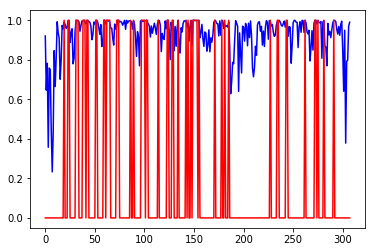

Epoch:2820, Loss: 0.010082957334816456


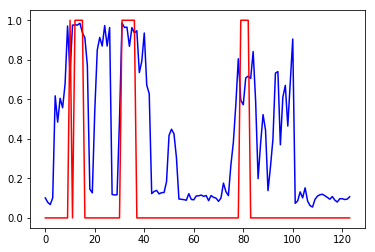

Epoch:2840, Loss: 0.014130848459899426


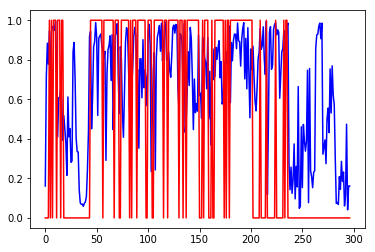

Epoch:2860, Loss: 0.012985732406377792


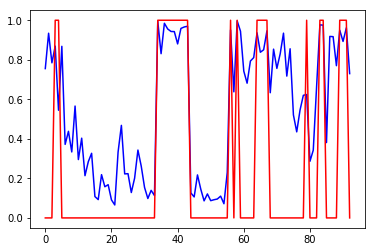

Epoch:2880, Loss: 0.008042245171964169


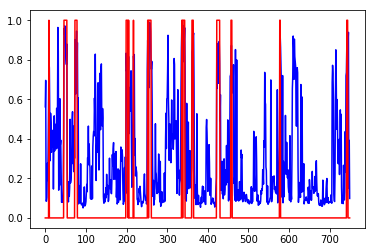

Epoch:2900, Loss: 0.013027383014559746


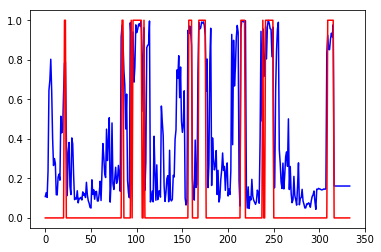

Epoch:2920, Loss: 0.013320691883563995


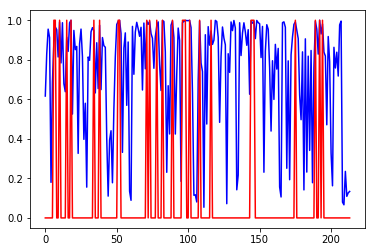

Epoch:2940, Loss: 0.009617526084184647


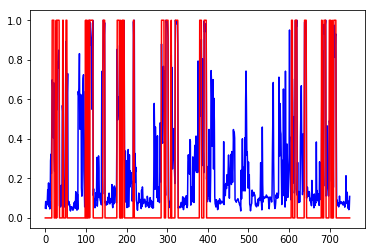

Epoch:2960, Loss: 0.009195568040013313


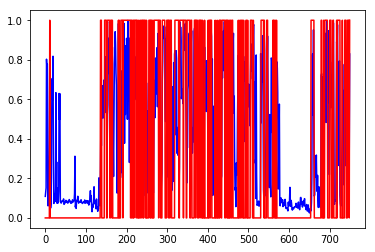

Epoch:2980, Loss: 0.009119057096540928


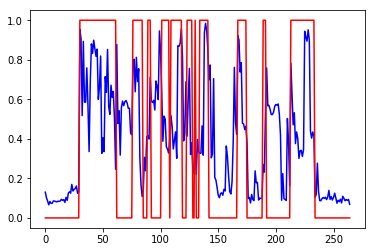

Epoch:3000, Loss: 0.010774224996566772


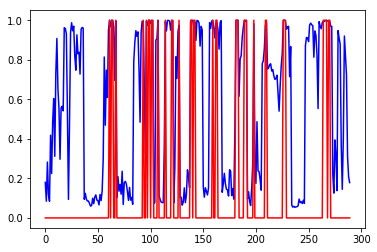

Epoch:3020, Loss: 0.009629233740270138


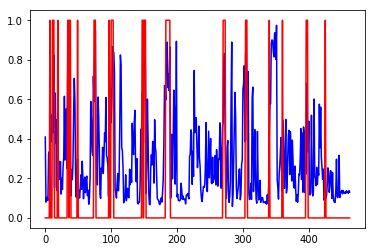

Epoch:3040, Loss: 0.011931011453270912


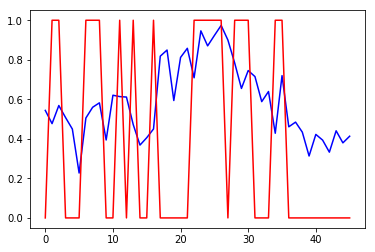

Epoch:3060, Loss: 0.01411713007837534


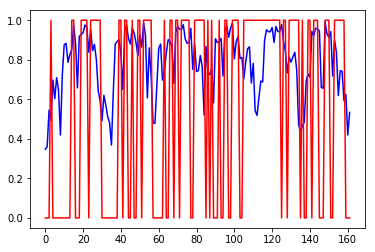

Epoch:3080, Loss: 0.010789446532726288


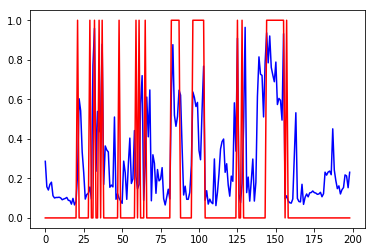

Epoch:3100, Loss: 0.01047756988555193


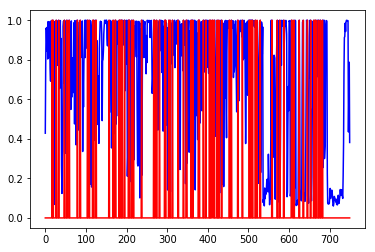

Epoch:3120, Loss: 0.010045899078249931


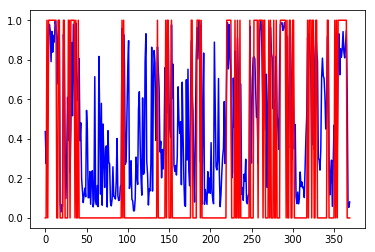

Epoch:3140, Loss: 0.009863363578915596


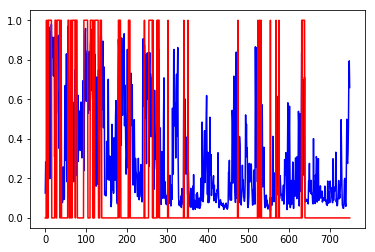

Epoch:3160, Loss: 0.009763315320014954


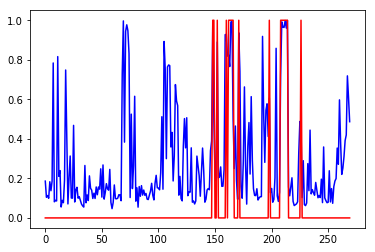

Epoch:3180, Loss: 0.00959741696715355


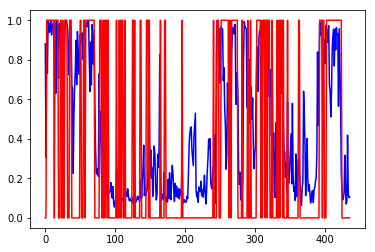

Epoch:3200, Loss: 0.010615421459078789


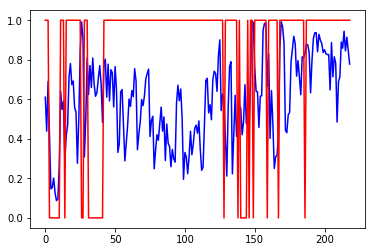

Epoch:3220, Loss: 0.008360380306839943


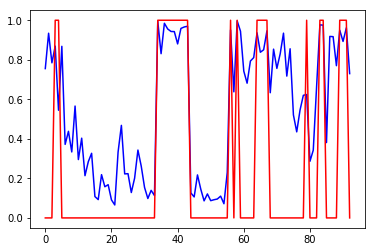

Epoch:3240, Loss: 0.010722005739808083


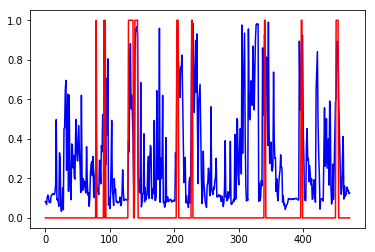

Epoch:3260, Loss: 0.007528961636126041


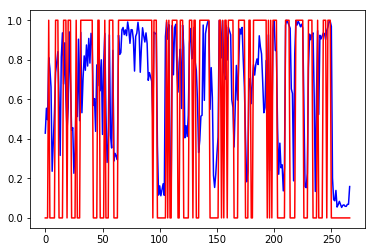

Epoch:3280, Loss: 0.010922981426119804


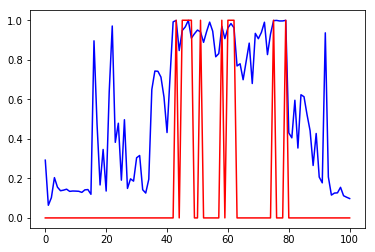

Epoch:3300, Loss: 0.010663695633411407


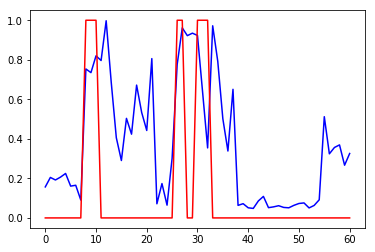

Epoch:3320, Loss: 0.008768130093812943


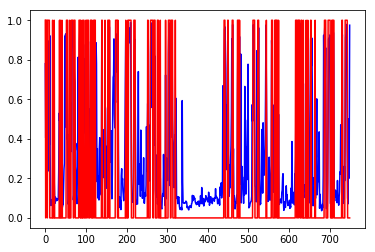

Epoch:3340, Loss: 0.010148255154490471


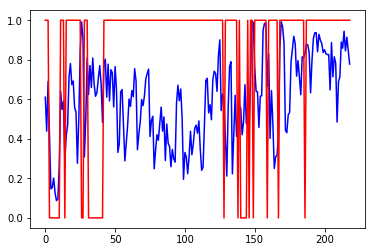

Epoch:3360, Loss: 0.008327178657054901


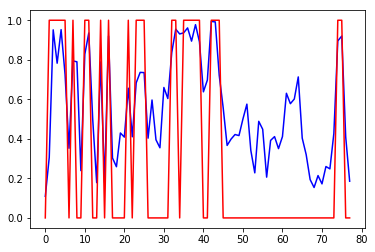

Epoch:3380, Loss: 0.01075795665383339


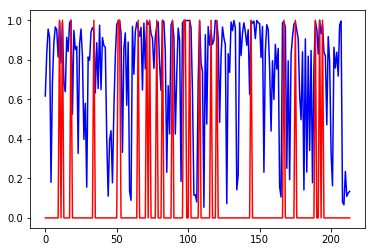

Epoch:3400, Loss: 0.006506198085844517


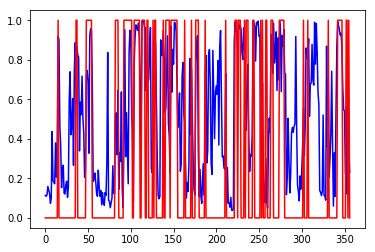

Epoch:3420, Loss: 0.01137727964669466


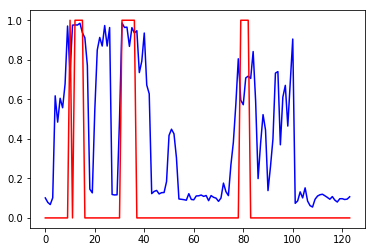

Epoch:3440, Loss: 0.009990561753511429


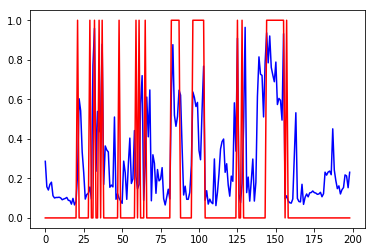

Epoch:3460, Loss: 0.011283041909337044


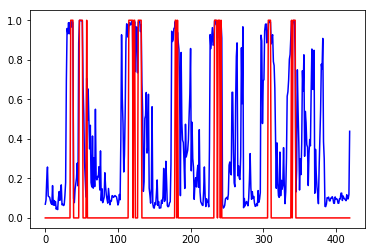

Epoch:3480, Loss: 0.00869558472186327


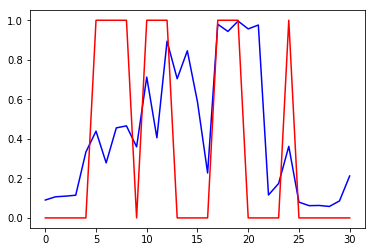

Epoch:3500, Loss: 0.011935954913496971


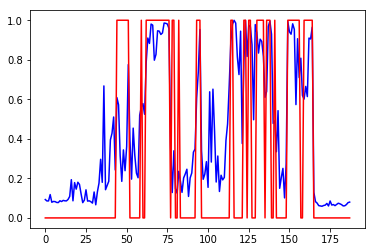

Epoch:3520, Loss: 0.011404037475585938


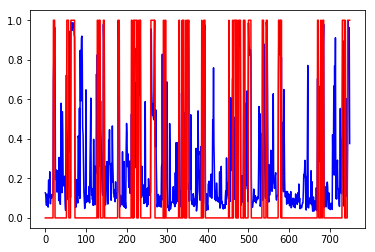

Epoch:3540, Loss: 0.010854523628950119


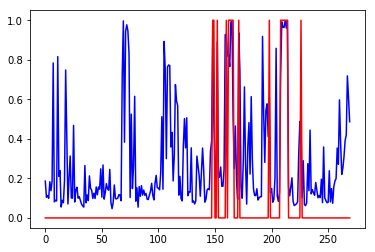

Epoch:3560, Loss: 0.0081513412296772


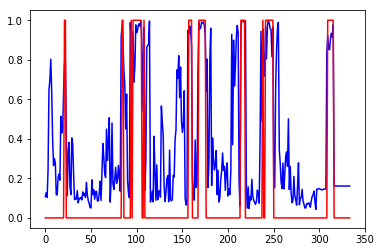

Epoch:3580, Loss: 0.013272089883685112


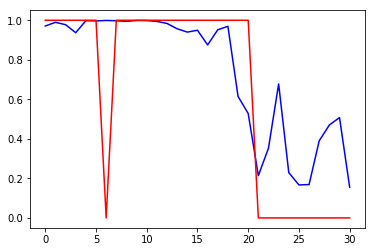

Epoch:3600, Loss: 0.008702958934009075


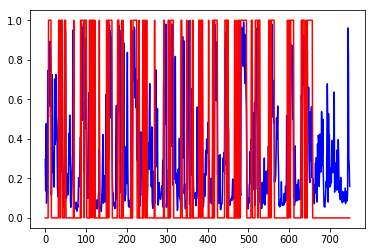

Epoch:3620, Loss: 0.011277053505182266


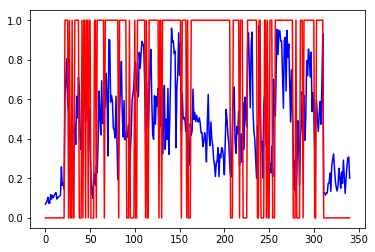

Epoch:3640, Loss: 0.008320569060742855


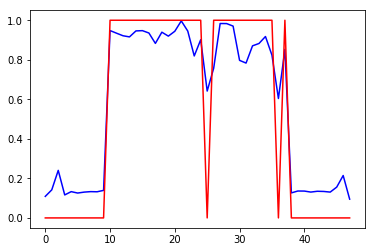

Epoch:3660, Loss: 0.008290671743452549


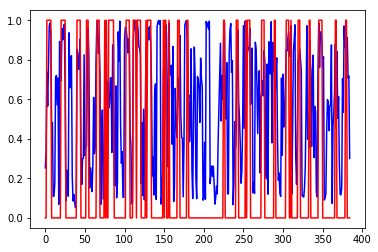

Epoch:3680, Loss: 0.009375520050525665


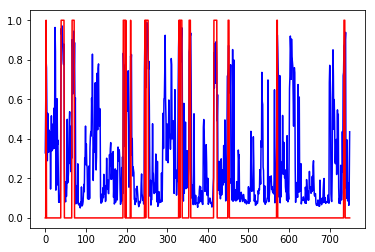

Epoch:3700, Loss: 0.009971902705729008


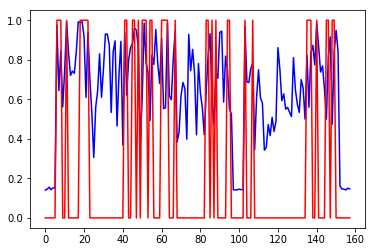

Epoch:3720, Loss: 0.010734008625149727


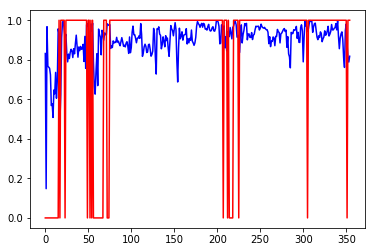

Epoch:3740, Loss: 0.01053057610988617


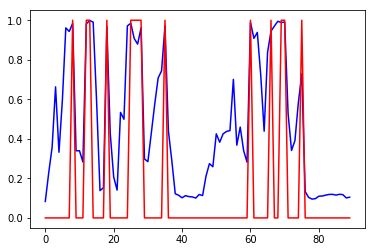

Epoch:3760, Loss: 0.013666216284036636


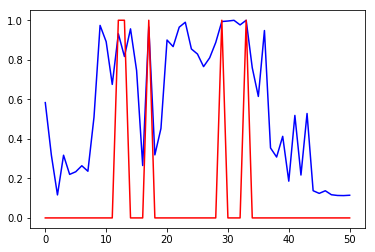

Epoch:3780, Loss: 0.011272688396275043


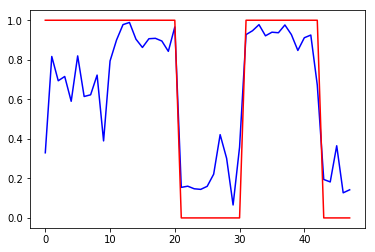

Epoch:3800, Loss: 0.012326362542808056


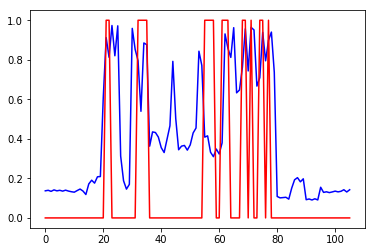

Epoch:3820, Loss: 0.00856778584420681


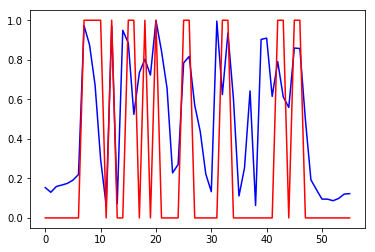

Epoch:3840, Loss: 0.007032311987131834


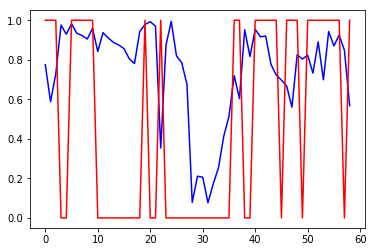

Epoch:3860, Loss: 0.009986881166696548


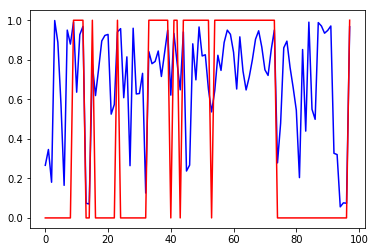

Epoch:3880, Loss: 0.009650979191064835


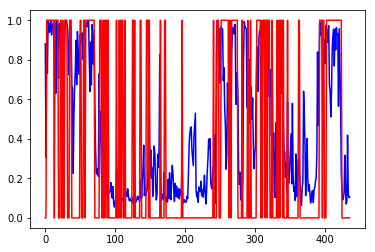

Epoch:3900, Loss: 0.01167951337993145


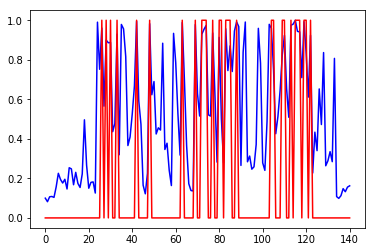

Epoch:3920, Loss: 0.009466092102229595


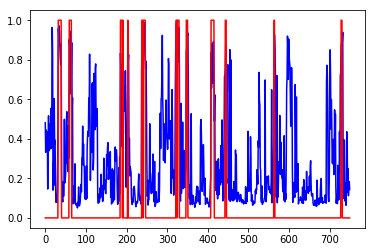

Epoch:3940, Loss: 0.008811047300696373


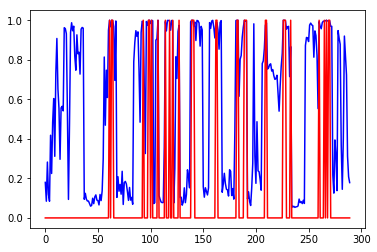

Epoch:3960, Loss: 0.009061738848686218


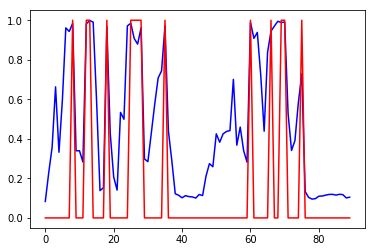

Epoch:3980, Loss: 0.009018776938319206


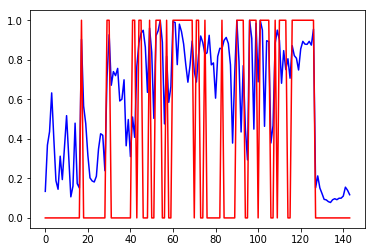

Epoch:4000, Loss: 0.009803349152207375


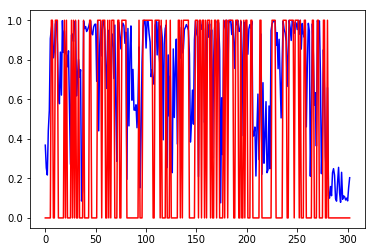

Epoch:4020, Loss: 0.012226882390677929


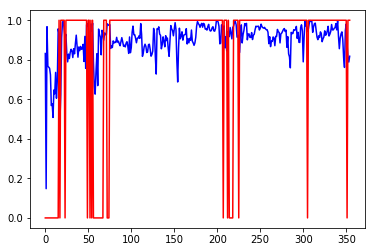

Epoch:4040, Loss: 0.010733794420957565


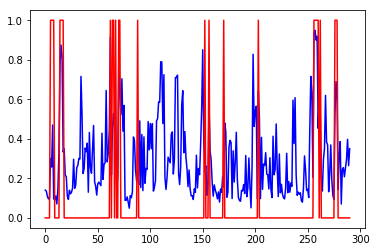

Epoch:4060, Loss: 0.011714816093444824


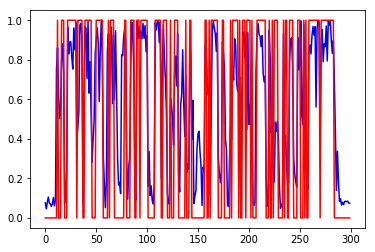

Epoch:4080, Loss: 0.009885907173156738


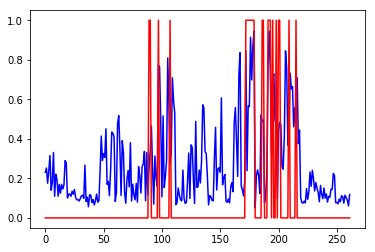

Epoch:4100, Loss: 0.010514281690120697


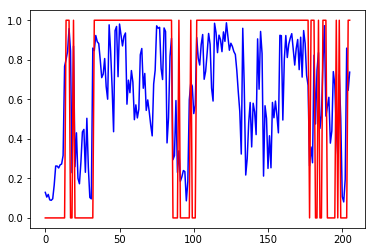

Epoch:4120, Loss: 0.008527952246367931


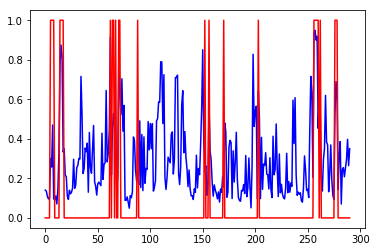

Epoch:4140, Loss: 0.010816213674843311


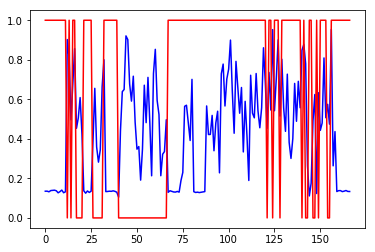

Epoch:4160, Loss: 0.011838888749480247


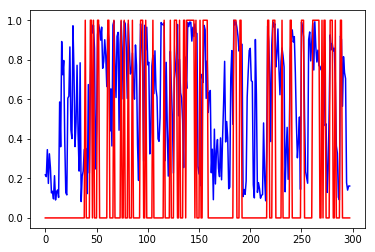

Epoch:4180, Loss: 0.010924289003014565


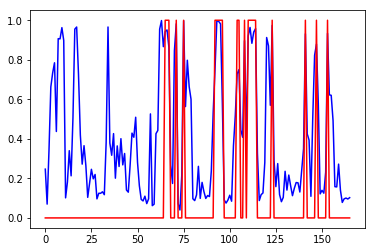

Epoch:4200, Loss: 0.008422385901212692


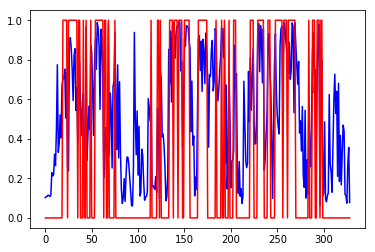

Epoch:4220, Loss: 0.008847531862556934


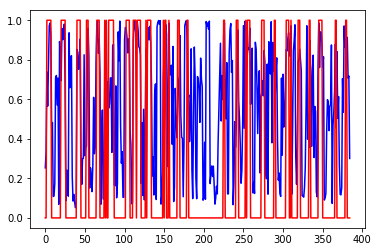

Epoch:4240, Loss: 0.009223157539963722


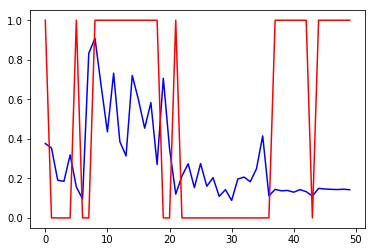

Epoch:4260, Loss: 0.007303623482584953


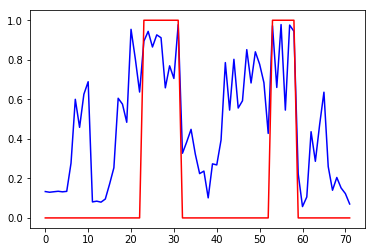

Epoch:4280, Loss: 0.00730902049690485


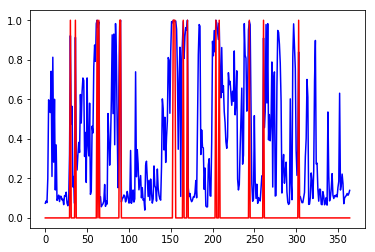

Epoch:4300, Loss: 0.009937884286046028


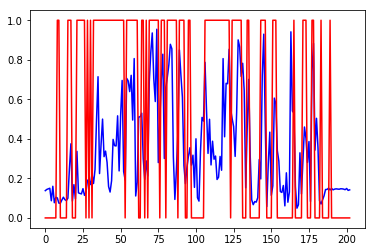

Epoch:4320, Loss: 0.008605691604316235


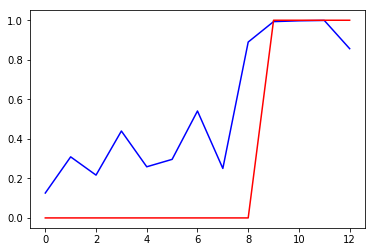

Epoch:4340, Loss: 0.008958585560321808


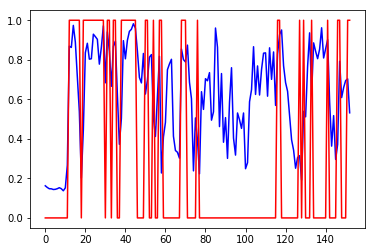

Epoch:4360, Loss: 0.008522555232048035


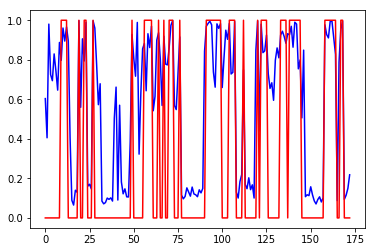

Epoch:4380, Loss: 0.01194626372307539


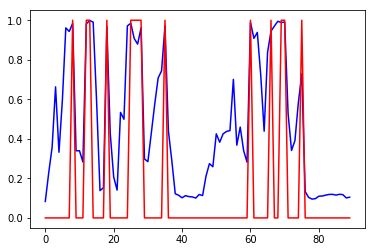

Epoch:4400, Loss: 0.009124217554926872


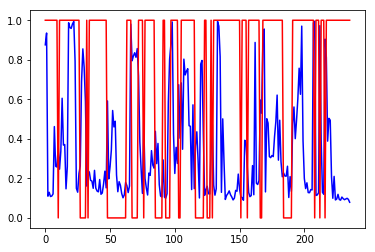

Epoch:4420, Loss: 0.010433396324515343


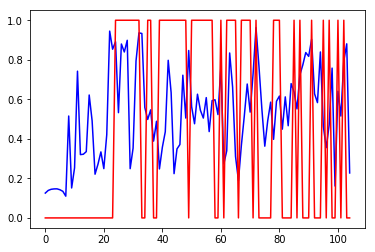

Epoch:4440, Loss: 0.007900714874267578


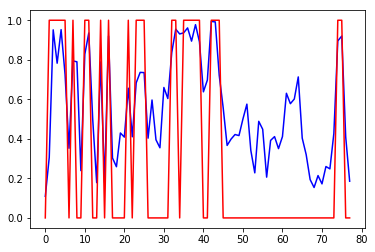

Epoch:4460, Loss: 0.007283288985490799


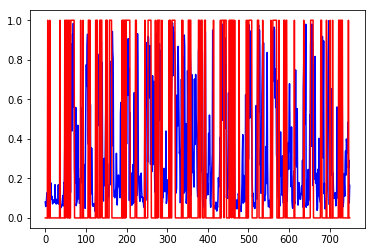

Epoch:4480, Loss: 0.007834602147340775


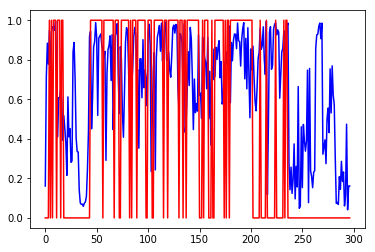

Epoch:4500, Loss: 0.011190753430128098


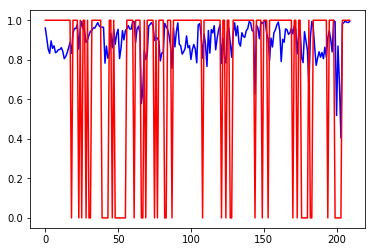

Epoch:4520, Loss: 0.006525435950607061


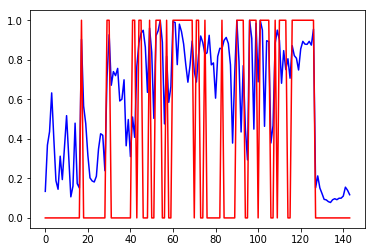

Epoch:4540, Loss: 0.010026860050857067


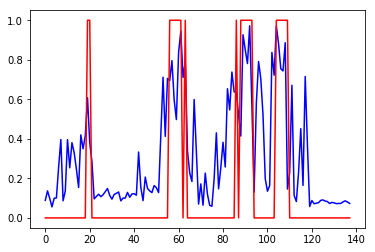

Epoch:4560, Loss: 0.009285207837820053


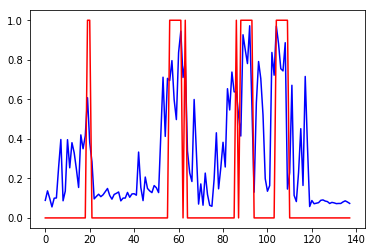

Epoch:4580, Loss: 0.00906806904822588


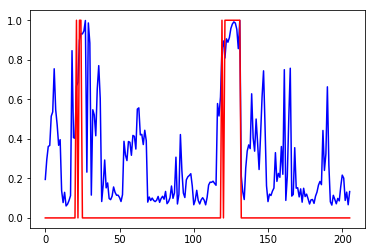

Epoch:4600, Loss: 0.00821519922465086


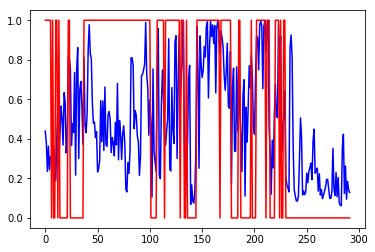

Epoch:4620, Loss: 0.012283075600862503


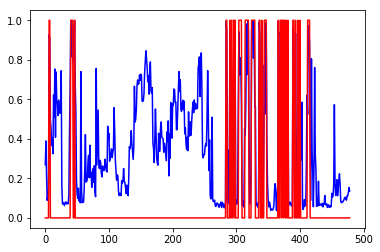

Epoch:4640, Loss: 0.010429253801703453


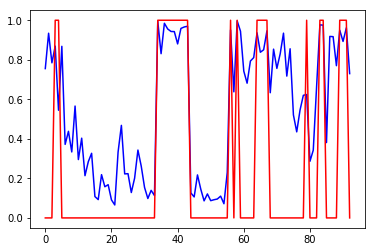

Epoch:4660, Loss: 0.00678333081305027


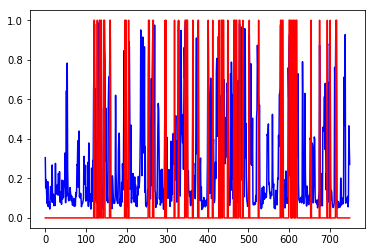

Epoch:4680, Loss: 0.009055864065885544


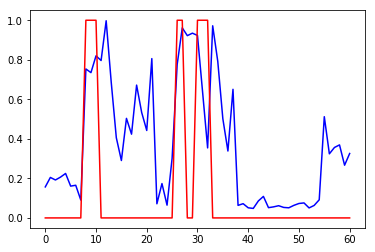

Epoch:4700, Loss: 0.007083014585077763


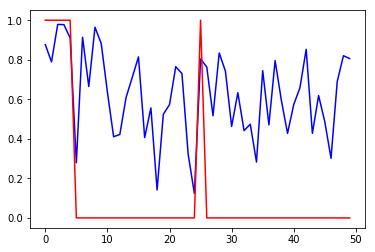

Epoch:4720, Loss: 0.00720747048035264


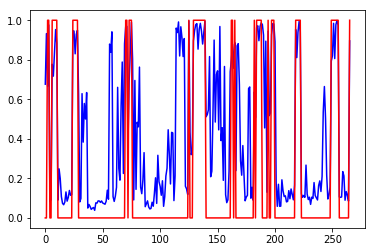

Epoch:4740, Loss: 0.007787237875163555


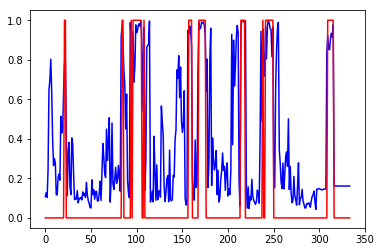

Epoch:4760, Loss: 0.010090326890349388


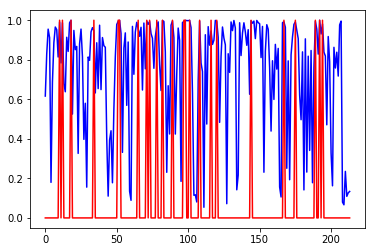

Epoch:4780, Loss: 0.012058058753609657


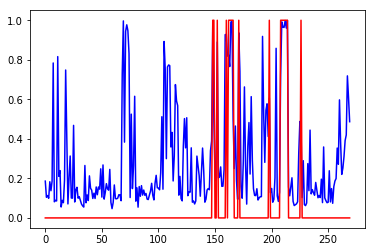

Epoch:4800, Loss: 0.0075860959477722645


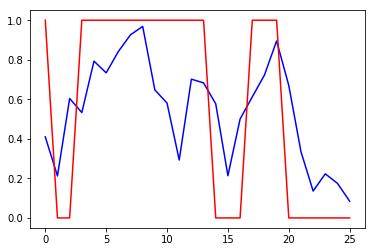

Epoch:4820, Loss: 0.007503860630095005


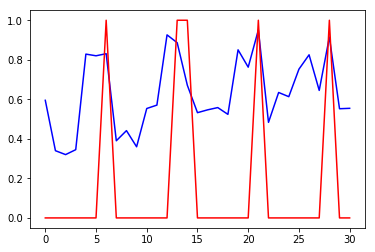

Epoch:4840, Loss: 0.011607795022428036


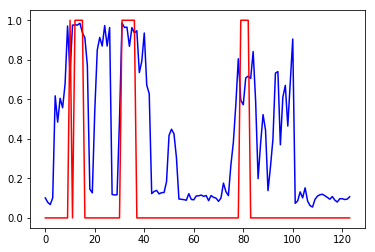

Epoch:4860, Loss: 0.010327698662877083


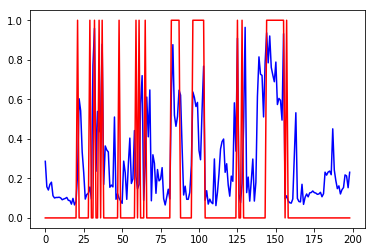

Epoch:4880, Loss: 0.010360813699662685


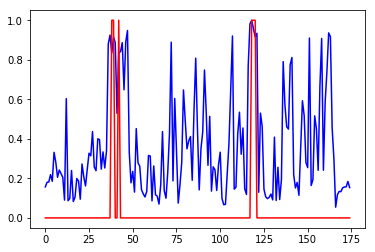

Epoch:4900, Loss: 0.007328850217163563


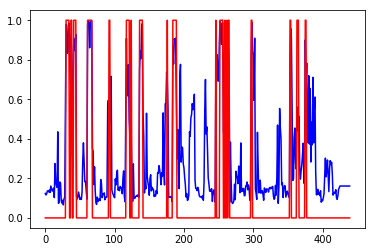

Epoch:4920, Loss: 0.010473860427737236


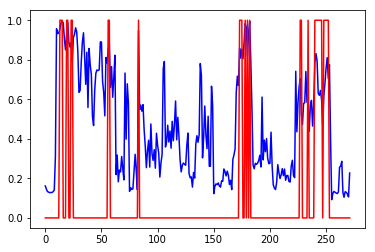

Epoch:4940, Loss: 0.0070469556376338005


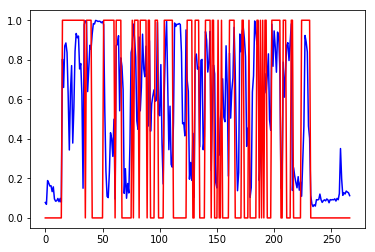

Epoch:4960, Loss: 0.0074369171634316444


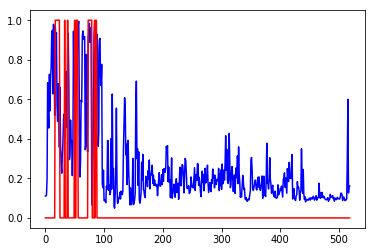

Epoch:4980, Loss: 0.007921472191810608


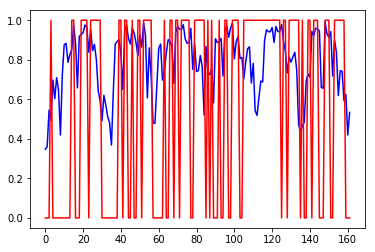

Epoch:5000, Loss: 0.008206048980355263


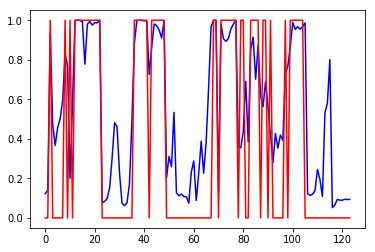

Epoch:5020, Loss: 0.010006225667893887


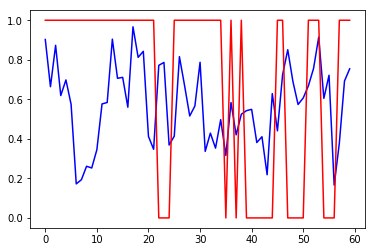

Epoch:5040, Loss: 0.008914060890674591


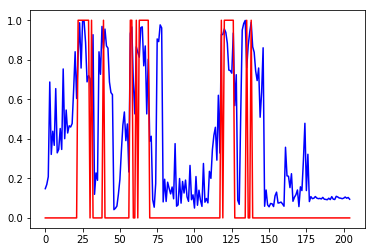

Epoch:5060, Loss: 0.010869091376662254


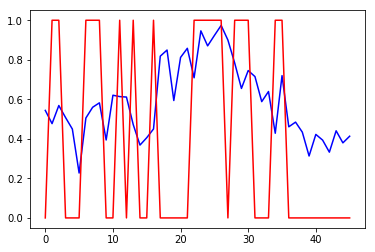

In [ ]:
for epoch in range(args.max_iter):
    # Randomly extract 10 video clips' I3D feature
    features, labels = dataset.load_data(n_similar=args.num_similar)

    # Features are alingned in 750 frames all the same, now trunk it into max length
    seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
    features = features[:,:np.max(seq_len),:]

    # Convert to CUDA tensor
    features = torch.from_numpy(features).float().to('cuda')
    labels = torch.from_numpy(labels).float().to('cuda')

    # Generate texts from categories
    text_list, labels = one_label_text(labels)

    # Generate Pos/Neg temporal segment mask for contrastive loss
#     if epoch < 0:
#         clses = [[idx for idx, cls in enumerate(label) if cls == 1.] for label in labels]
#         t_proposals = temporal_proposals(args.weights, features.detach().cpu(), clses)
#         attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features\
#             = model(features, text_list, t_proposals)
            
#         # Squared Loss, Margin Ranking Loss
#         pos_distance = euclidean_distance(pos_feature, textual_feature, 1)
#         neg_distance = euclidean_distance(neg_feature, textual_feature, 1)
#         target = torch.zeros(visual_feature.shape[0]).cuda()-1
#         margin_loss = marginrankingloss(pos_distance, neg_distance, target)
#         loss = euclidean_distance(visual_feature, textual_feature) + args.margin_weight*margin_loss 
#     else:

    # Visualize T-CAM result for comparison
    clses = [[idx for idx, cls in enumerate(label) if cls == 1.] for label in labels]
    t_proposals = temporal_proposals(args.weights, features.detach().cpu(), clses)
    
    # Predict
    attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features\
        = model(features, text_list, None)
    loss = adaptive_margin_loss(pos_feature, neg_feature, textual_feature)
        

    # Back Propogation
    optimizer.zero_grad() 
    loss.backward()  
    optimizer.step()
            
    # Save checkpoint
    if epoch % 3000 == 0 and epoch is not 0:
        # Reduce lr 
        args.tao /= 2
        args.lr /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
        
        # Checkpoint structure
        model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }
        torch.save(model_state, os.path.join(args.checkpoint_path, 'model_nlp_top-down_gumbel_epoch_{:03}.pth'.format(epoch)))
    
    # Print out training loss
    loss_value = loss.detach().cpu().tolist()
    writer.add_scalar('runs/', loss_value, epoch)       

    if epoch % 20 == 0:
        print('Epoch:{:03}, Loss: {:02}'.format(epoch, loss_value))
        # Display attention weights and loss value
        plt.plot(attention_weights[0].tolist(), c='b')
        plt.plot(t_proposals[0], c='r')
        plt.show()
        
# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()

## Test Temporal Localization of Language Weakly Training

In [1]:
# Duo Model testing

# Load pre trained model
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

model = Model(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)

checkpoint = torch.load('./checkpoint/model_nlp_top-down_gumbel_epoch_5000.pth')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

model.eval()
model.cuda()


print('model loaded')

NameError: name 'Model' is not defined

In [ ]:
# Similarities among visual-textual features
def visual_textual_sim(sing_video_feat, cls_num=20):
    """
        return (segments, class_num)
    """
    # Compute Similarities Across Video-Textual features
    weights = np.zeros((sing_video_feat.shape[0], cls_num))
    for idx1, seg_feat in enumerate(sing_video_feat):
        for idx2 in range(cls_num):
            # Randomly picking out one textual label
            rand = np.random.randint(len(language_feat_dict[idx2]))
            textual_feat = language_feat_dict[idx2][rand]
            weights[idx1, idx2] = euclidean_distance(textual_feat, seg_feat)
    return weights


def test(itr, dataset, args, model, logger, device):
    
    done = False
    instance_logits_stack = []
    element_logits_stack = []
    labels_stack = []
    while not done:
        if dataset.currenttestidx % 100 ==0:
            print('Testing test data point %d of %d' %(dataset.currenttestidx, len(dataset.testidx)))

        features, labels, done = dataset.load_data(is_training=False)
        features = torch.from_numpy(features).float().to(device)
        labels = torch.from_numpy(labels).float().to(device)

        # Generate texts from categories (in test mode return text list and single class list)
        text_list, sing_labels = one_label_text(labels, True)

        attention_list = []
        # Iterate through class within one sample
        for text, label in zip(text_list, sing_labels):
            attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features \
                = model([features], text[0], None, test=True)
            attention_list.append(attention_weights[0])

        # Computing T-cam weights
        weights = temp2(len(attention_weights[0]), attention_list, labels)
        weights = weights.detach().cpu().numpy() 
            
        element_logits_stack.append(weights)
        labels_stack.append(labels.tolist())

    labels_stack = np.array(labels_stack)
    
    dmap, iou = dmAP(element_logits_stack, dataset.path_to_annotations)
    
    if args.dataset_name == 'Thumos14':
        test_set = sio.loadmat('test_set_meta.mat')['test_videos'][0]
        for i in range(np.shape(labels_stack)[0]):
            if test_set[i]['background_video'] == 'YES':
                labels_stack[i, :] = np.zeros_like(labels_stack[i,:])

    print('Detection map @ %f = %f' %(iou[0], dmap[0]))
    print('Detection map @ %f = %f' %(iou[1], dmap[1]))
    print('Detection map @ %f = %f' %(iou[2], dmap[2]))
    print('Detection map @ %f = %f' %(iou[3], dmap[3]))
    print('Detection map @ %f = %f' %(iou[4], dmap[4]))

    return element_logits_stack, labels_stack

In [2]:
from tensorboard_logger import Logger
logger = Logger('./logs/' + 'Testing')
device = torch.device("cuda")

element_logits_stack, labels_stack = test(0, dataset, args, model, logger, device)

NameError: name 'torch' is not defined

In [43]:
from tensorboard_logger import Logger
logger = Logger('./logs/' + 'Testing')
device = torch.device("cuda")

element_logits_stack, labels_stack = test(0, dataset, args, model, logger, device)

Testing test data point 0 of 212
Error here, not valid label assigned for this test case!
Testing test data point 100 of 212
Testing test data point 200 of 212
Testing for IoU 0.100000
Testing for IoU 0.200000
Testing for IoU 0.300000
Testing for IoU 0.400000
Testing for IoU 0.500000
Detection map @ 0.100000 = 43.901852
Detection map @ 0.200000 = 36.235663
Detection map @ 0.300000 = 27.862039
Detection map @ 0.400000 = 19.218444
Detection map @ 0.500000 = 12.518680
